In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns


# export_graphviz: 나무 구조 생성 및 저장 
from sklearn.tree import export_graphviz
# graphviz : 나무 구조 시각화  (.dot 확장자 파일 불러오기 등)
import graphviz
# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 예측/회귀 Random Forest
from sklearn.ensemble import RandomForestRegressor
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV
# 예측/회귀 Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor


import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler

# 선형 회귀분석모델 formula(y ~ X1 + X2 + ...)
import statsmodels.formula.api as smf
# 회귀분석의 정규성 확인
from statsmodels.api import qqplot

In [3]:
Car_raw = pd.read_csv("/home/piai/2~5주차/2. Big Data 분석/Car.csv")
Car_raw

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 kmpl,998 CC,58.16 bhp,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7248,Volkswagen Vento Diesel Trendline,Hyderabad,NaN,2011,89411,Diesel,Manual,First,20.54 kmpl,1598 CC,103.6 bhp,5.0,NaN
7249,Volkswagen Polo GT TSI,Mumbai,NaN,2015,59000,Petrol,Automatic,First,17.21 kmpl,1197 CC,103.6 bhp,5.0,NaN
7250,Nissan Micra Diesel XV,Kolkata,NaN,2012,28000,Diesel,Manual,First,23.08 kmpl,1461 CC,63.1 bhp,5.0,NaN
7251,Volkswagen Polo GT TSI,Pune,NaN,2013,52262,Petrol,Automatic,Third,17.2 kmpl,1197 CC,103.6 bhp,5.0,NaN


# 1. 데이터 전처리

In [4]:
# Car_raw 'null bhp' -> null값으로 대체
Car_raw['Power'] = Car_raw['Power'].replace('null bhp', pd.NA)
Car_raw.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                 175
Seats                  53
New_Price            6247
dtype: int64

In [5]:
# Car_raw '0.0 kmpl' -> null값으로 대체 
Car_raw['Mileage'] = Car_raw['Mileage'].replace('0.0 kmpl', pd.NA)
Car_raw.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                83
Engine                 46
Power                 175
Seats                  53
New_Price            6247
dtype: int64

## 단위제거 (Mileage, Engine, Power, New_Price)

In [6]:
# 1. Mileage 열 처리 (NaN 제외하고 변환)
Car_raw['Mileage'] = (
    Car_raw['Mileage']
    .dropna()  # NaN 제외
    .astype(str)  # 문자열로 변환
    .str.extract(r'(\d+\.?\d*)')  # 숫자와 소수점 추출
    .astype(float)  # float으로 변환
)

# 2. Engine 열 처리 (NaN 제외하고 변환)
Car_raw['Engine'] = (
    Car_raw['Engine']
    .dropna()  # NaN 제외
    .astype(str)  # 문자열로 변환
    .str.extract(r'(\d+\.?\d*)')  # 숫자만 추출
    .astype(float)  # 정수로 변환 (CC는 보통 정수로 표시)
)

# 3. Power 열 처리 (NaN 제외하고 변환)
Car_raw['Power'] = (
    Car_raw['Power']
    .dropna()  # NaN 제외
    .astype(str)  # 문자열로 변환
    .str.extract(r'(\d+\.?\d*)')  # 숫자와 소수점 추출
    .astype(float)  # float으로 변환
)

# 4. New_Price 열 처리 (NaN 제외하고 변환)
Car_raw['New_Price'] = (
    Car_raw['New_Price']
    .dropna()  # NaN 제외
    .astype(str)  # 문자열로 변환
    .str.extract(r'(\d+\.?\d*)')  # 숫자와 소수점 추출
    .astype(float)  # float으로 변환
)

## Name을 brand+model 로 나눔

In [7]:
#Name을 Brand Model 로 나눔
Car_raw['Name'] = Car_raw['Name'].str.upper()
Car_raw['Brand'] = Car_raw['Name'].str.split(' ', 1).str[0]  # 첫 단어를 브랜드로
Car_raw['Model'] = Car_raw['Name'].str.split(' ', 1).str[1]  # 나머지를 모델명으로

In [8]:
Car_raw = Car_raw.sort_values(by='Name')

## 주행거리를 기준으로 등급 분류

In [9]:
# 주행거리 기준으로 등급 분류 함수 정의
def classify_kilometers(km):
    if km <= 20000:
        return 1
    elif 20000 < km <= 40000:
        return 2
    elif 40000 < km <= 60000:
        return 3
    elif 60000 < km <= 80000:
        return 4
    elif 80000 < km <= 100000:
        return 5
    else:
        return 6

# 등급 분류 열 추가
Car_raw['Kilometer_Range_Grade'] = Car_raw['Kilometers_Driven'].apply(classify_kilometers)

In [10]:
Car_raw

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Brand,Model,Kilometer_Range_Grade
1221,AMBASSADOR CLASSIC NOVA DIESEL,Chennai,2069.50,2003,80000,Diesel,Manual,Third,12.80,1489.0,35.5,5.0,NaN,AMBASSADOR,CLASSIC NOVA DIESEL,4
6663,AUDI A3 35 TDI ATTRACTION,Ahmedabad,NaN,2014,84004,Diesel,Automatic,First,20.38,1968.0,143.0,5.0,NaN,AUDI,A3 35 TDI ATTRACTION,5
398,AUDI A3 35 TDI ATTRACTION,Chennai,25293.84,2014,79271,Diesel,Automatic,First,20.38,1968.0,143.0,5.0,NaN,AUDI,A3 35 TDI ATTRACTION,4
4782,AUDI A3 35 TDI PREMIUM,Mumbai,29509.48,2016,20003,Diesel,Automatic,First,20.38,1968.0,143.0,5.0,NaN,AUDI,A3 35 TDI PREMIUM,2
4989,AUDI A3 35 TDI PREMIUM PLUS,Mumbai,28972.94,2016,39000,Diesel,Automatic,First,20.38,1968.0,143.0,5.0,42.89,AUDI,A3 35 TDI PREMIUM PLUS,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,VOLVO XC60 D5 INSCRIPTION,Kochi,26336.25,2014,86925,Diesel,Automatic,First,11.20,2400.0,215.0,5.0,NaN,VOLVO,XC60 D5 INSCRIPTION,5
4497,VOLVO XC90 2007-2015 D5 AT AWD,Kochi,36147.20,2014,102001,Diesel,Automatic,First,11.10,2400.0,200.0,7.0,NaN,VOLVO,XC90 2007-2015 D5 AT AWD,6
6384,VOLVO XC90 2007-2015 D5 AWD,Bangalore,NaN,2016,70000,Diesel,Manual,First,11.10,2400.0,200.0,7.0,NaN,VOLVO,XC90 2007-2015 D5 AWD,4
2401,VOLVO XC90 2007-2015 D5 AWD,Kochi,36254.50,2014,89230,Diesel,Manual,First,11.10,2400.0,200.0,7.0,NaN,VOLVO,XC90 2007-2015 D5 AWD,5


In [11]:
Car_raw.isnull().sum()

Name                        0
Location                    0
Price                    1053
Year                        0
Kilometers_Driven           0
Fuel_Type                   0
Transmission                0
Owner_Type                  0
Mileage                    83
Engine                     46
Power                     175
Seats                      53
New_Price                6247
Brand                       0
Model                       0
Kilometer_Range_Grade       0
dtype: int64

## 변수별 시각화

Text(0.5, 1.0, 'Price Distribution')

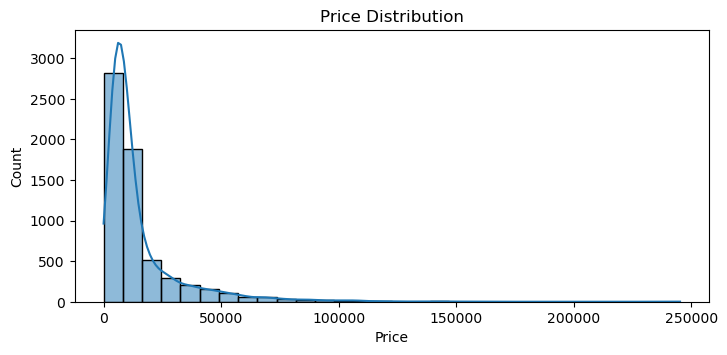

In [12]:
plt.figure(figsize=(18, 12))

# Price 히스토그램
plt.subplot(3, 2, 1)
sns.histplot(Car_raw['Price'].dropna(), bins=30, kde=True)
plt.title('Price Distribution')


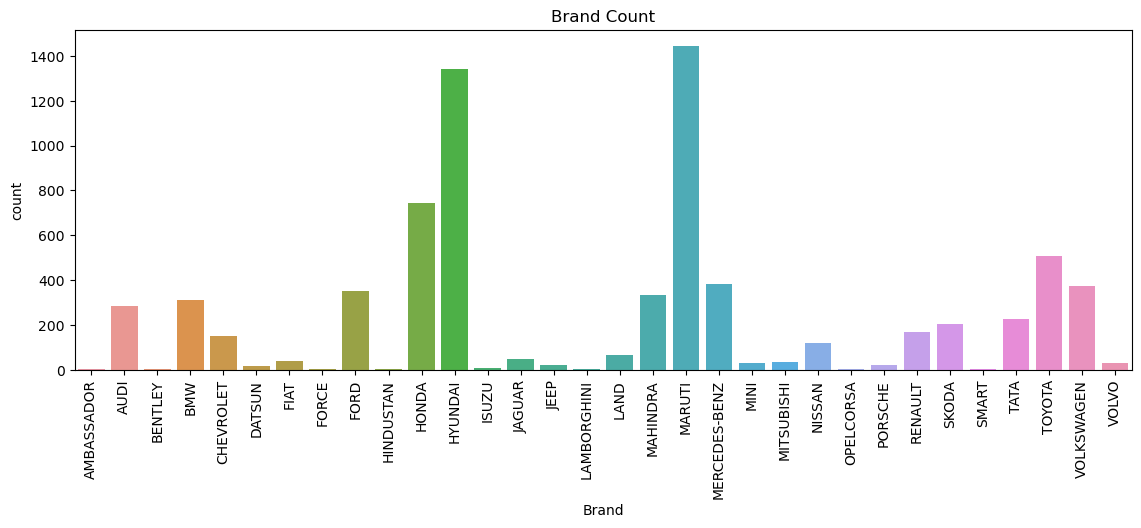

In [13]:
plt.figure(figsize=(30, 15))

# Brand 막대 그래프 (Bar Chart)
plt.subplot(3, 2, 6)
sns.countplot(x=Car_raw['Brand'])
plt.title('Brand Count')

# x축 레이블 90도 회전
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

Text(0.5, 1.0, 'Location Count')

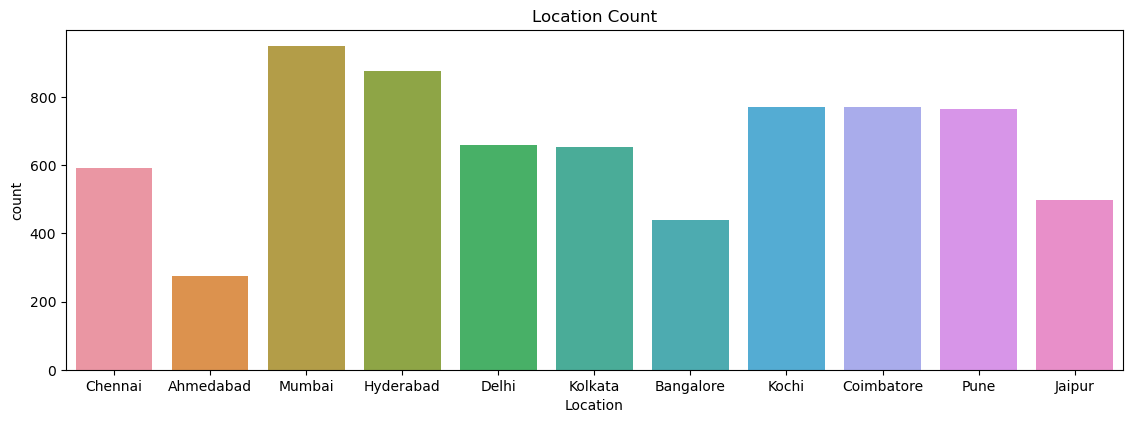

In [14]:
plt.figure(figsize=(30, 15))

# Location 막대 그래프 (Bar Chart)
plt.subplot(3, 2, 6)
sns.countplot(x=Car_raw['Location'])
plt.title('Location Count')

Text(0.5, 1.0, 'Year Distribution')

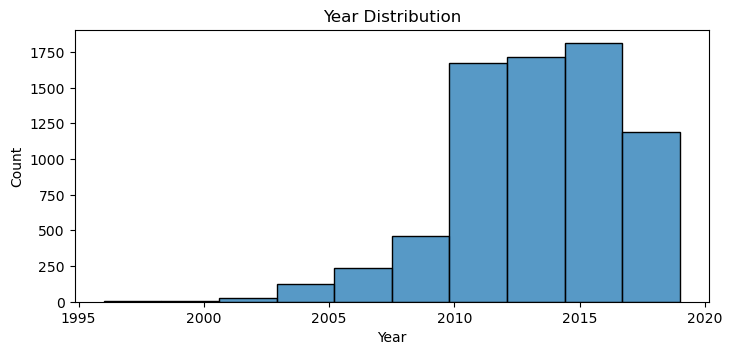

In [15]:
plt.figure(figsize=(18, 12))

# Year 히스토그램
plt.subplot(3, 2, 2)
sns.histplot(Car_raw['Year'], bins=10, kde=False)
plt.title('Year Distribution')


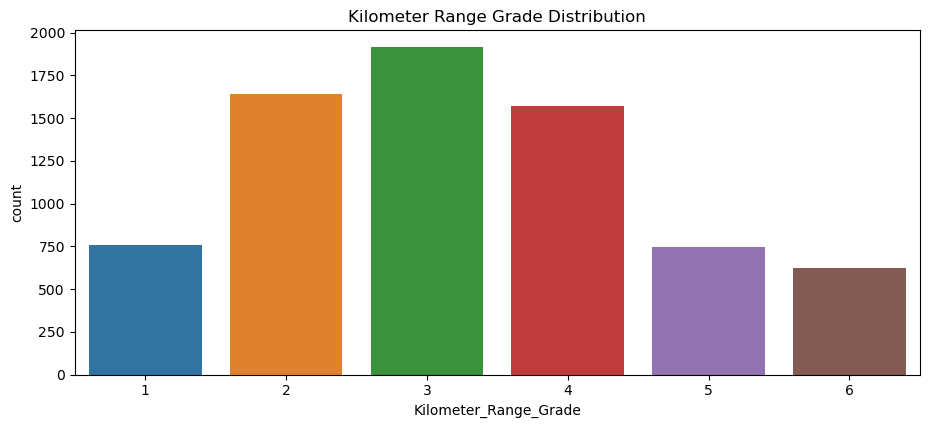

In [16]:
plt.figure(figsize=(18, 12))

# Kilometer_Range_Grade 막대 그래프
plt.subplot(3, 2, 2)
sns.countplot(x='Kilometer_Range_Grade', data=Car_raw)
plt.title('Kilometer Range Grade Distribution')

# 그래프 표시
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Fuel Type Count')

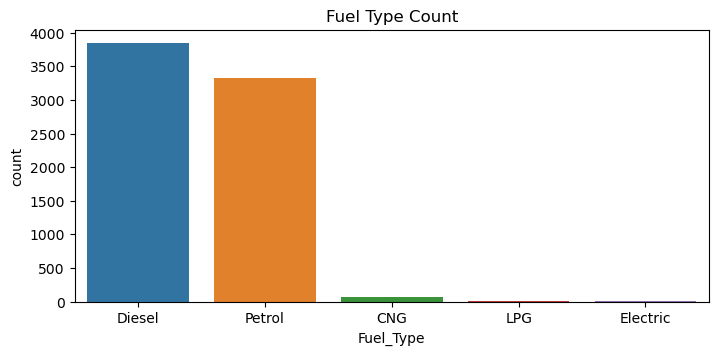

In [17]:
plt.figure(figsize=(18, 12))

# Fuel_Type 막대 그래프 (Bar Chart)
plt.subplot(3, 2, 4)
sns.countplot(x=Car_raw['Fuel_Type'])
plt.title('Fuel Type Count')


Text(0.5, 1.0, 'Transmission Type Count')

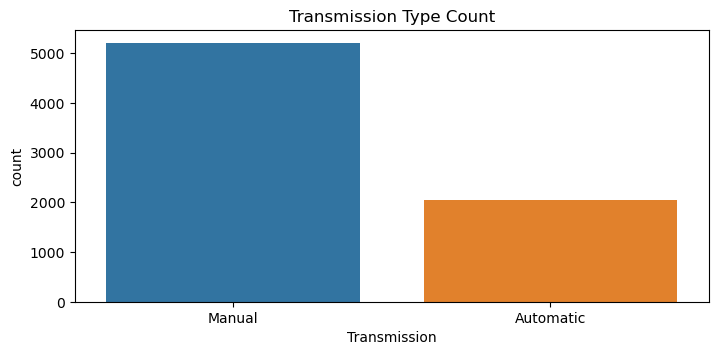

In [18]:
plt.figure(figsize=(18, 12))

# Transmission 막대 그래프 (Bar Chart)
plt.subplot(3, 2, 5)
sns.countplot(x=Car_raw['Transmission'])
plt.title('Transmission Type Count')


First             5952
Fourth & Above      12
Second            1152
Third              137
Name: Owner_Type, dtype: int64


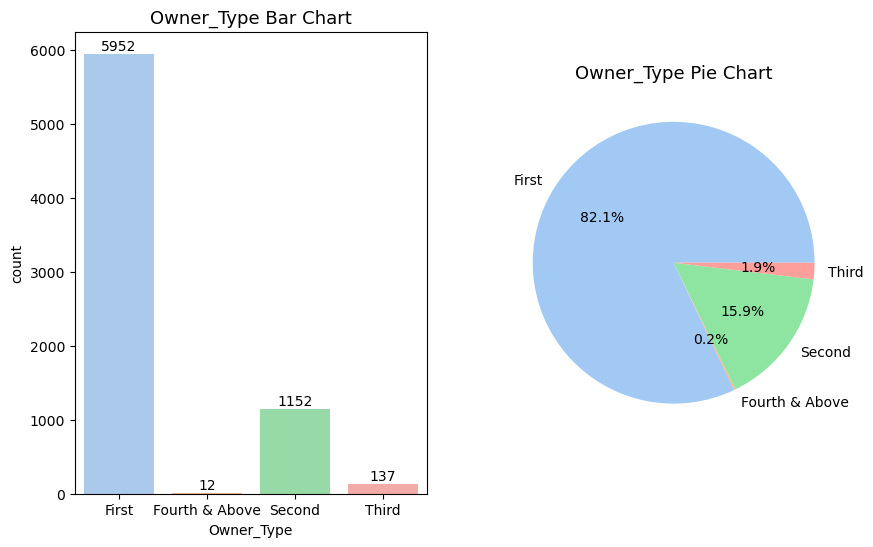

In [19]:
#Owner_Type 
plc_counts = Car_raw['Owner_Type'].value_counts().sort_index()
print(plc_counts)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))

colors = sns.color_palette("pastel", len(plc_counts))

p2=sns.countplot(x='Owner_Type', data=Car_raw, ax=axs[0], palette=colors, order=plc_counts.index)
axs[0].bar_label(p2.containers[0], fmt='%d') 
axs[1].pie(plc_counts, labels=plc_counts.index, autopct='%.1f%%', colors=colors)

axs[0].set_title('Owner_Type Bar Chart', fontsize=13)
axs[1].set_title('Owner_Type Pie Chart', fontsize=13)
plt.show()

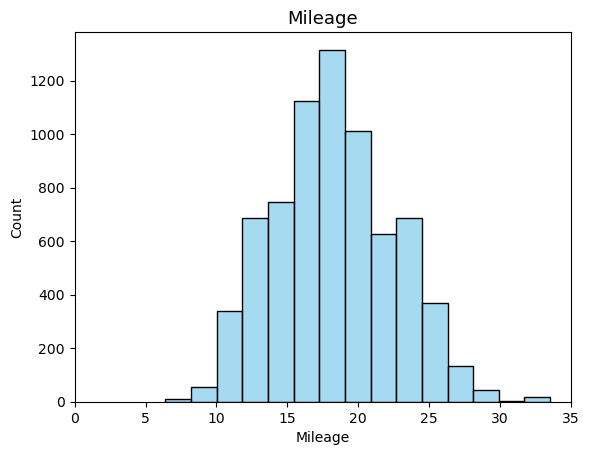

In [20]:
# Mileage
sns.histplot(data=Car_raw, x='Mileage', bins=15, color="skyblue")
plt.title('Mileage', fontsize=13)
plt.xticks(np.arange(0, 40, 5))
plt.show()

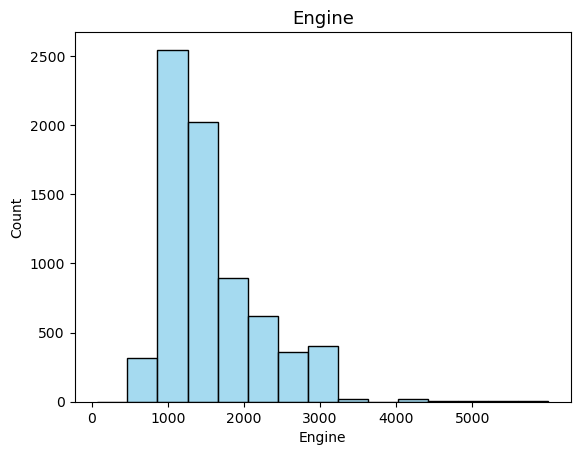

In [21]:
# Engine
sns.histplot(data=Car_raw, x='Engine', bins=15,  color="skyblue")
plt.title('Engine', fontsize=13)
plt.xticks(np.arange(0, 6000, 1000))
plt.show()

Text(0.5, 1.0, 'Power Distribution')

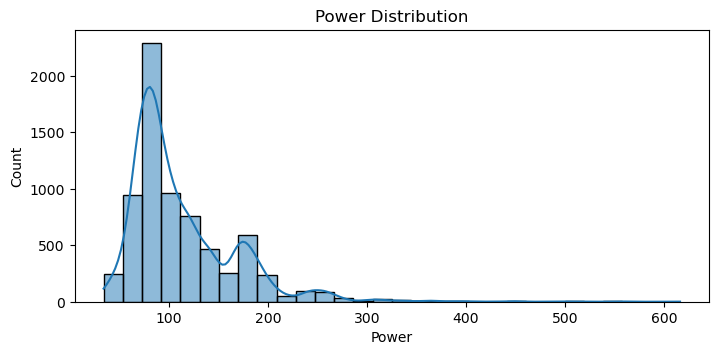

In [22]:
plt.figure(figsize=(18, 12))

# Power 히스토그램
plt.subplot(3, 2, 1)
sns.histplot(Car_raw['Power'].dropna(), bins=30, kde=True)
plt.title('Power Distribution')

0.0        1
2.0       18
4.0      119
5.0     6047
6.0       38
7.0      796
8.0      170
9.0        3
10.0       8
Name: Seats, dtype: int64


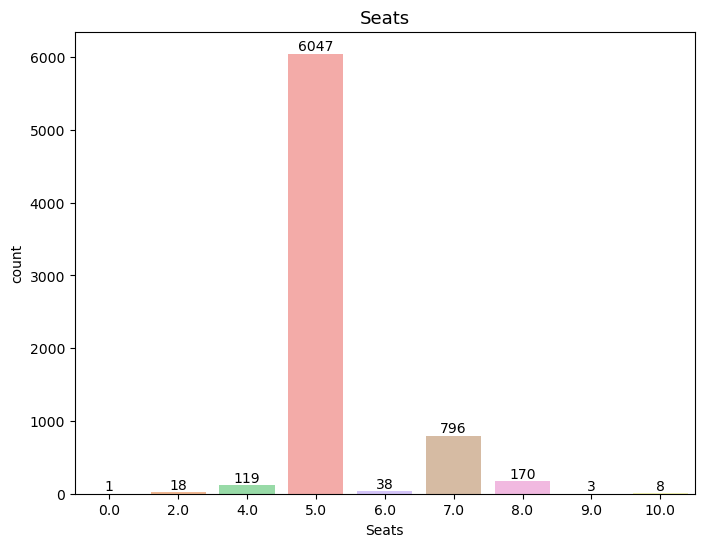

In [23]:
# Seats 
plc_counts = Car_raw['Seats'].value_counts().sort_index()
print(plc_counts)

fig, ax = plt.subplots(figsize=(8, 6))

colors = sns.color_palette("pastel", len(plc_counts))

p2 = sns.countplot(x='Seats', data=Car_raw, ax=ax, palette=colors, order=plc_counts.index)
ax.bar_label(p2.containers[0], fmt='%d') 

ax.set_title('Seats', fontsize=13)

plt.show()

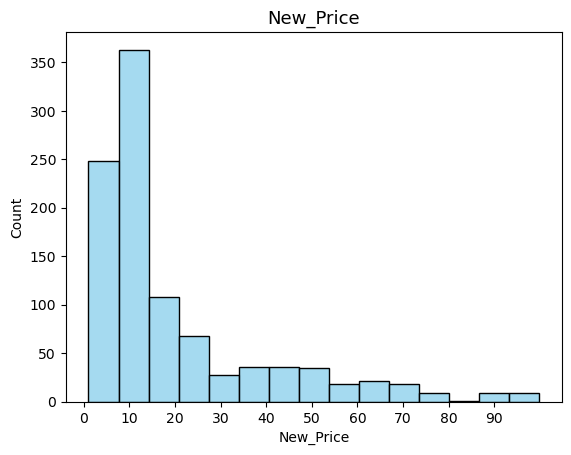

In [24]:
# New Price
sns.histplot(data=Car_raw, x='New_Price', bins=15,  color="skyblue")
plt.title('New_Price', fontsize=13)
plt.xticks(np.arange(0, 100, 10))
plt.show()

## 결측치 대체

In [25]:
Car_raw.isnull().sum()

Name                        0
Location                    0
Price                    1053
Year                        0
Kilometers_Driven           0
Fuel_Type                   0
Transmission                0
Owner_Type                  0
Mileage                    83
Engine                     46
Power                     175
Seats                      53
New_Price                6247
Brand                       0
Model                       0
Kilometer_Range_Grade       0
dtype: int64

In [26]:
#Price 1053개 결측치 대체 수행(Name-주행등급 같은 애들의 중앙값으로 대체)
grouped_median = Car_raw.groupby(['Name', 'Kilometer_Range_Grade'])['Price'].transform('median')
Car_raw['Price'] = Car_raw['Price'].where(Car_raw['Price'].notna(), grouped_median)

Car_raw.isnull().sum()

Name                        0
Location                    0
Price                     361
Year                        0
Kilometers_Driven           0
Fuel_Type                   0
Transmission                0
Owner_Type                  0
Mileage                    83
Engine                     46
Power                     175
Seats                      53
New_Price                6247
Brand                       0
Model                       0
Kilometer_Range_Grade       0
dtype: int64

In [27]:
#Price 361개 결측치 대체 수행(Brand-주행등급 같은 애들의 중앙값으로 대체)
grouped_median = Car_raw.groupby(['Brand', 'Kilometer_Range_Grade'])['Price'].transform('median')
Car_raw['Price'] = Car_raw['Price'].where(Car_raw['Price'].notna(), grouped_median)

Car_raw.isnull().sum()

Name                        0
Location                    0
Price                       4
Year                        0
Kilometers_Driven           0
Fuel_Type                   0
Transmission                0
Owner_Type                  0
Mileage                    83
Engine                     46
Power                     175
Seats                      53
New_Price                6247
Brand                       0
Model                       0
Kilometer_Range_Grade       0
dtype: int64

In [28]:
# 'Price' 열에 NaN이 있는 행만 삭제 
Car_raw = Car_raw.dropna(subset=['Price'])
# 결과 확인
Car_raw.isnull().sum()

Name                        0
Location                    0
Price                       0
Year                        0
Kilometers_Driven           0
Fuel_Type                   0
Transmission                0
Owner_Type                  0
Mileage                    83
Engine                     46
Power                     174
Seats                      53
New_Price                6243
Brand                       0
Model                       0
Kilometer_Range_Grade       0
dtype: int64

In [29]:
#Mileage, power, engine, seat 같은 변수들은 출고 시 확정 되는 변수들, 이름이 같으면 값대체 수행
def fill_missing_values(df, column):
    return df[column].fillna(df.groupby('Name')[column].transform('first'))

# 결측치 대체 수행
Car_raw['Mileage'] = fill_missing_values(Car_raw, 'Mileage')
Car_raw['Power'] = fill_missing_values(Car_raw, 'Power')
Car_raw['Engine'] = fill_missing_values(Car_raw, 'Engine')
Car_raw['Seats'] = fill_missing_values(Car_raw, 'Seats')

Car_raw.isnull().sum()

Name                        0
Location                    0
Price                       0
Year                        0
Kilometers_Driven           0
Fuel_Type                   0
Transmission                0
Owner_Type                  0
Mileage                    80
Engine                     40
Power                     135
Seats                      46
New_Price                6243
Brand                       0
Model                       0
Kilometer_Range_Grade       0
dtype: int64

In [30]:
Car_raw=Car_raw.dropna(subset=['Engine','Power','Mileage'])
Car_raw.isnull().sum()

Name                        0
Location                    0
Price                       0
Year                        0
Kilometers_Driven           0
Fuel_Type                   0
Transmission                0
Owner_Type                  0
Mileage                     0
Engine                      0
Power                       0
Seats                       0
New_Price                6075
Brand                       0
Model                       0
Kilometer_Range_Grade       0
dtype: int64

In [31]:
Car_raw = Car_raw.drop(columns=['New_Price'])
Car_raw.isnull().sum()

Name                     0
Location                 0
Price                    0
Year                     0
Kilometers_Driven        0
Fuel_Type                0
Transmission             0
Owner_Type               0
Mileage                  0
Engine                   0
Power                    0
Seats                    0
Brand                    0
Model                    0
Kilometer_Range_Grade    0
dtype: int64

In [32]:
Car_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7076 entries, 1221 to 6659
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   7076 non-null   object 
 1   Location               7076 non-null   object 
 2   Price                  7076 non-null   float64
 3   Year                   7076 non-null   int64  
 4   Kilometers_Driven      7076 non-null   int64  
 5   Fuel_Type              7076 non-null   object 
 6   Transmission           7076 non-null   object 
 7   Owner_Type             7076 non-null   object 
 8   Mileage                7076 non-null   float64
 9   Engine                 7076 non-null   float64
 10  Power                  7076 non-null   float64
 11  Seats                  7076 non-null   float64
 12  Brand                  7076 non-null   object 
 13  Model                  7076 non-null   object 
 14  Kilometer_Range_Grade  7076 non-null   int64  
dtypes

In [33]:
Car_raw.to_csv("Preprocessed_Car.csv", index=False)
Car_raw.count()

Name                     7076
Location                 7076
Price                    7076
Year                     7076
Kilometers_Driven        7076
Fuel_Type                7076
Transmission             7076
Owner_Type               7076
Mileage                  7076
Engine                   7076
Power                    7076
Seats                    7076
Brand                    7076
Model                    7076
Kilometer_Range_Grade    7076
dtype: int64

## 이상치 처리

<Axes: >

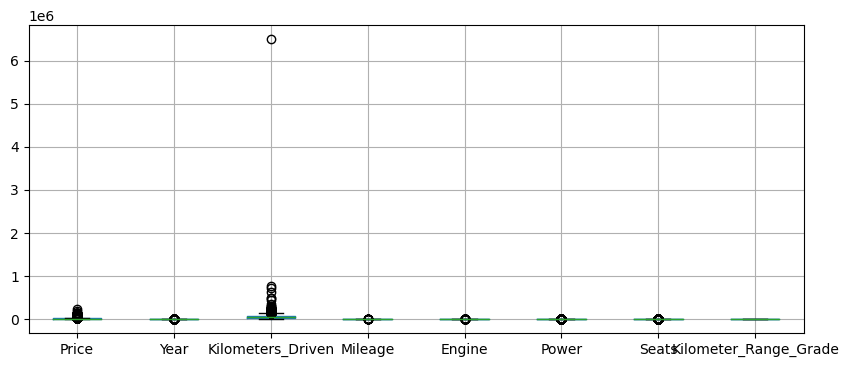

In [34]:
Car_raw.boxplot(figsize=(10,4))

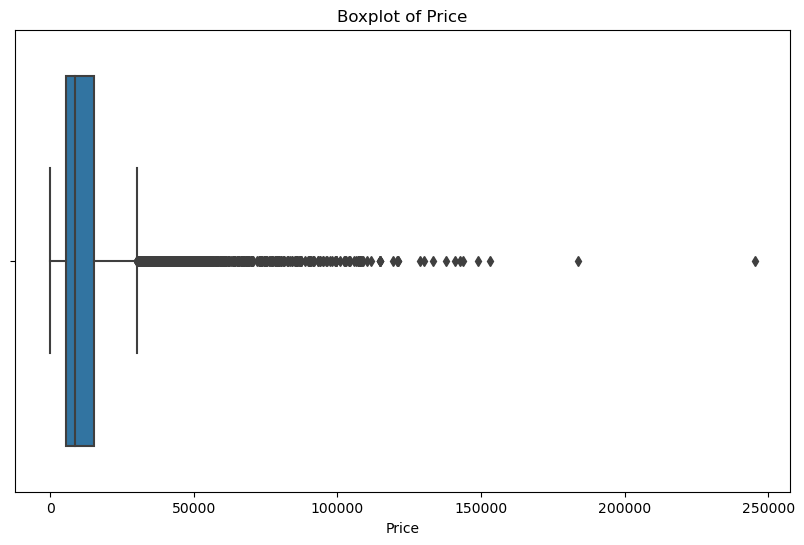

In [35]:
# Price 이상치 확인

plt.figure(figsize=(10, 6))
sns.boxplot(x=Car_raw['Price'])
plt.title('Boxplot of Price')
plt.xlabel('Price')
plt.show()

In [36]:
new_titanic = Car_raw[Car_raw["Price"] > 200000 ]
new_titanic 

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Model,Kilometer_Range_Grade
4079,LAND ROVER RANGE ROVER 3.0 DIESEL LWB VOGUE,Hyderabad,245273.6,2017,25000,Diesel,Automatic,First,13.33,2993.0,255.0,5.0,LAND,ROVER RANGE ROVER 3.0 DIESEL LWB VOGUE,2


In [37]:
new_titanic = Car_raw[(Car_raw["Price"] >= 150000) & (Car_raw["Price"] <= 200000)]
new_titanic

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Model,Kilometer_Range_Grade
5919,JAGUAR F TYPE 5.0 V8 S,Hyderabad,153296.0,2015,8000,Petrol,Automatic,First,12.5,5000.0,488.1,2.0,JAGUAR,F TYPE 5.0 V8 S,1
5781,LAMBORGHINI GALLARDO COUPE,Delhi,183955.2,2011,6500,Petrol,Automatic,Third,6.4,5204.0,560.0,2.0,LAMBORGHINI,GALLARDO COUPE,1


가격의 이상치는 모델과 브랜마다 다르므로 현재 중고차 가격과 튀는 값이 동일하므로 가격에는 이상치가 없다고 판단

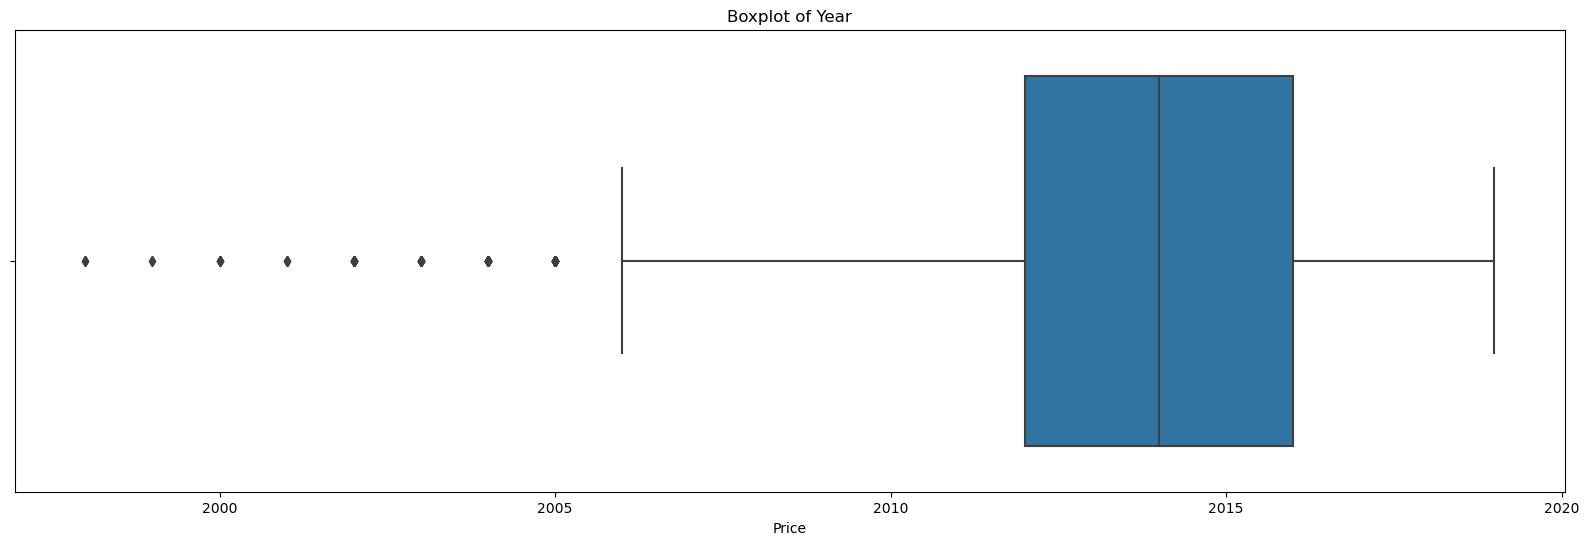

In [38]:
# Year 이상치

plt.figure(figsize=(20, 6))
sns.boxplot(x=Car_raw['Year'])
plt.title('Boxplot of Year')
plt.xlabel('Price')
plt.show()

In [39]:
new_titanic = Car_raw['Year'].value_counts()
new_titanic

2015    922
2014    920
2016    877
2013    787
2017    707
2012    670
2011    568
2010    393
2018    360
2009    237
2008    190
2007    127
2019    115
2006     76
2005     53
2004     30
2003     17
2002     13
2000      5
2001      4
1998      3
1999      2
Name: Year, dtype: int64

Year 이상치는 없다고 판단.

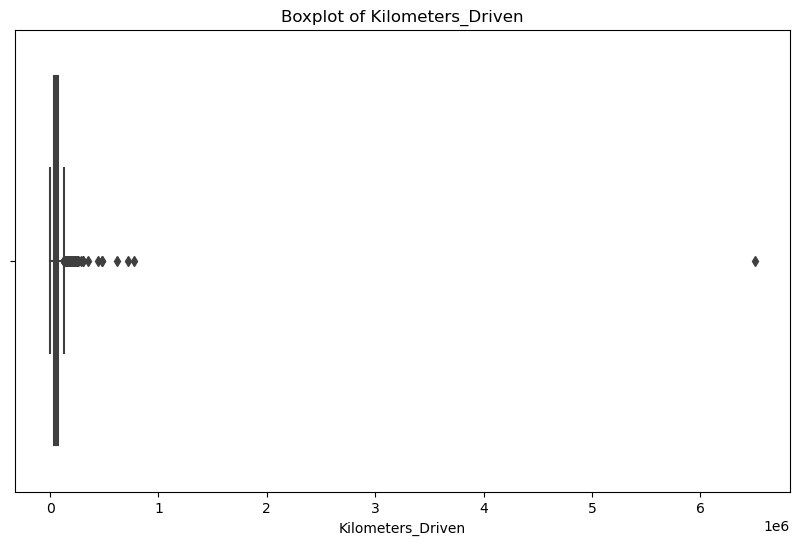

In [40]:
# kilometer_Driven 이상치

plt.figure(figsize=(10, 6))
sns.boxplot(x=Car_raw['Kilometers_Driven'])
plt.title('Boxplot of Kilometers_Driven')
plt.xlabel('Kilometers_Driven')
plt.show()



In [41]:
new_titanic = Car_raw[(Car_raw["Kilometers_Driven"] >= 6000000)]
new_titanic

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Model,Kilometer_Range_Grade
2328,BMW X5 XDRIVE 30D M SPORT,Chennai,99642.4,2017,6500000,Diesel,Automatic,First,15.97,2993.0,258.0,5.0,BMW,X5 XDRIVE 30D M SPORT,6


In [42]:
test =Car_raw[ Car_raw["Name"]=='BMW X5 XDRIVE 30D M SPORT']
test

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Model,Kilometer_Range_Grade
4101,BMW X5 XDRIVE 30D M SPORT,Chennai,87378.72,2016,45000,Diesel,Automatic,First,15.97,2993.0,258.0,5.0,BMW,X5 XDRIVE 30D M SPORT,3
2328,BMW X5 XDRIVE 30D M SPORT,Chennai,99642.40,2017,6500000,Diesel,Automatic,First,15.97,2993.0,258.0,5.0,BMW,X5 XDRIVE 30D M SPORT,6
5740,BMW X5 XDRIVE 30D M SPORT,Chennai,84312.80,2017,21000,Diesel,Automatic,Second,15.97,2993.0,258.0,5.0,BMW,X5 XDRIVE 30D M SPORT,2


Price 는 비슷한데, 주행거리가 이상하므로 이상치 제거

In [43]:
Car_raw = Car_raw.drop(index=2328)

# 인덱스 재정렬 
Car_raw = Car_raw.reset_index(drop=True)
Car_raw.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Model,Kilometer_Range_Grade
0,AMBASSADOR CLASSIC NOVA DIESEL,Chennai,2069.50,2003,80000,Diesel,Manual,Third,12.80,1489.0,35.5,5.0,AMBASSADOR,CLASSIC NOVA DIESEL,4
1,AUDI A3 35 TDI ATTRACTION,Ahmedabad,26918.78,2014,84004,Diesel,Automatic,First,20.38,1968.0,143.0,5.0,AUDI,A3 35 TDI ATTRACTION,5
2,AUDI A3 35 TDI ATTRACTION,Chennai,25293.84,2014,79271,Diesel,Automatic,First,20.38,1968.0,143.0,5.0,AUDI,A3 35 TDI ATTRACTION,4
3,AUDI A3 35 TDI PREMIUM,Mumbai,29509.48,2016,20003,Diesel,Automatic,First,20.38,1968.0,143.0,5.0,AUDI,A3 35 TDI PREMIUM,2
4,AUDI A3 35 TDI PREMIUM PLUS,Mumbai,28972.94,2016,39000,Diesel,Automatic,First,20.38,1968.0,143.0,5.0,AUDI,A3 35 TDI PREMIUM PLUS,2


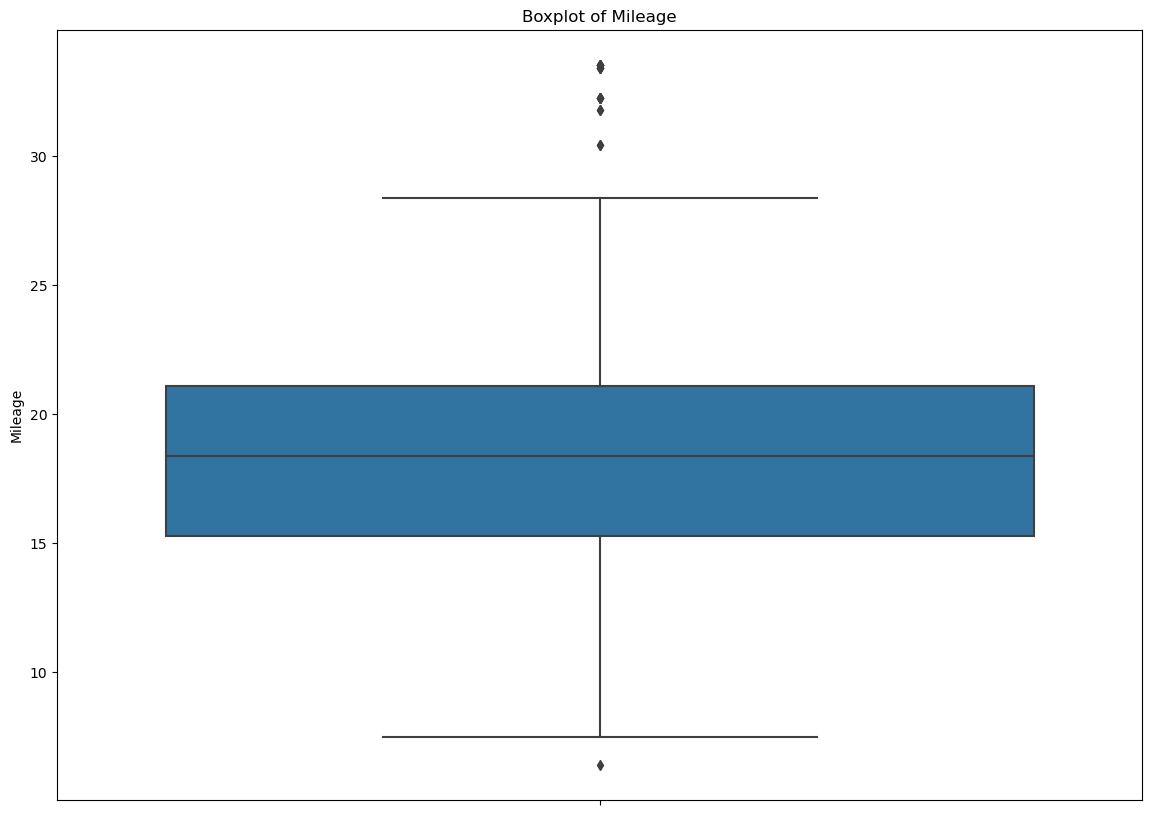

In [44]:
# Mileage 이상치

plt.figure(figsize=(14, 10))
sns.boxplot(y=Car_raw['Mileage'])
plt.title("Boxplot of Mileage")
plt.ylabel("Mileage")
plt.show()

In [45]:
filtered_data = Car_raw[(Car_raw["Mileage"] >= 2) & (Car_raw["Mileage"] <= 7)]
filtered_data

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Model,Kilometer_Range_Grade
3217,LAMBORGHINI GALLARDO COUPE,Delhi,183955.2,2011,6500,Petrol,Automatic,Third,6.4,5204.0,560.0,2.0,LAMBORGHINI,GALLARDO COUPE,1


마일리지는 이상치가 없는 것으로 판단

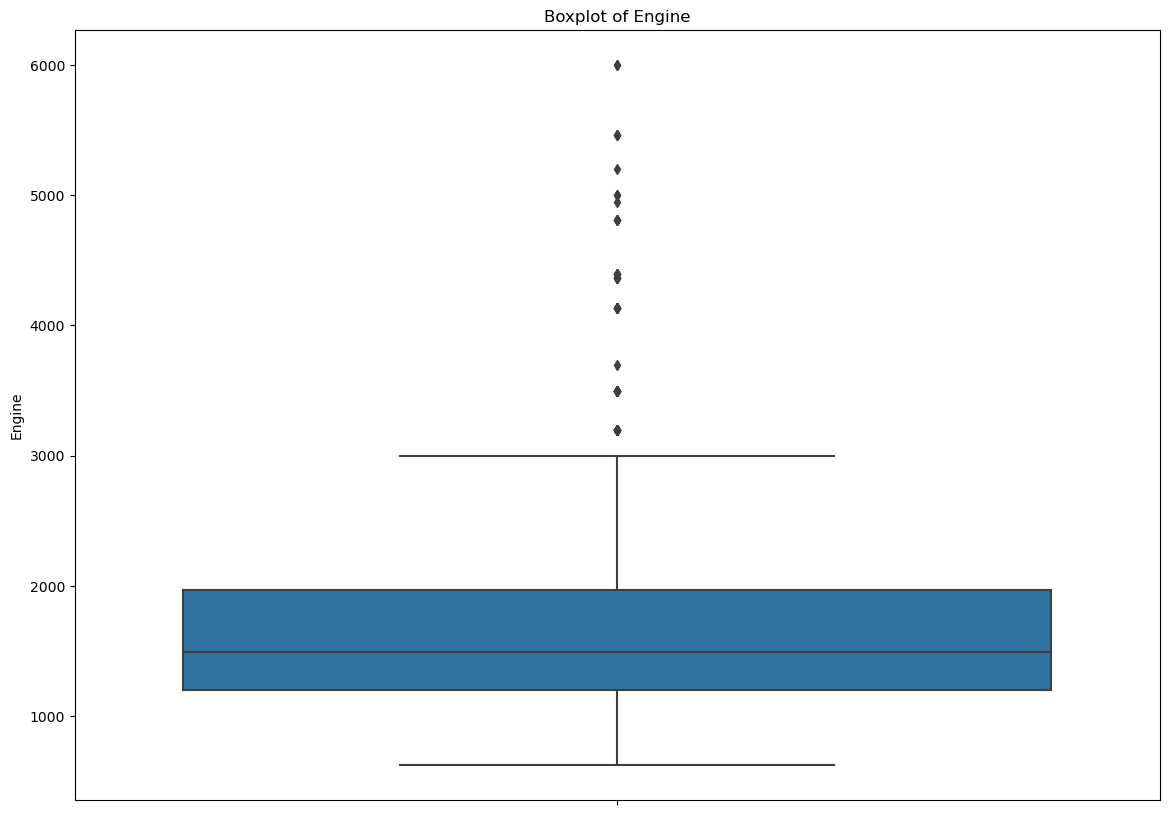

In [46]:
# Engine 이상치
plt.figure(figsize=(14, 10))
sns.boxplot(y=Car_raw['Engine'])
plt.title("Boxplot of Engine")
plt.ylabel("Engine")
plt.show()


In [47]:
new_titanic = Car_raw['Engine'].value_counts()
new_titanic

1197.0    734
1248.0    604
1498.0    369
998.0     309
1198.0    282
         ... 
2706.0      1
3696.0      1
3200.0      1
1468.0      1
1489.0      1
Name: Engine, Length: 141, dtype: int64

Engine의 이상치로 판단되는 값들을 출력하여 확인한 결과, 실제 모델들의 Power와 동일한 것을 확인할 수 있었다. 즉 Power는 이상치가 없다고 판단 된다.


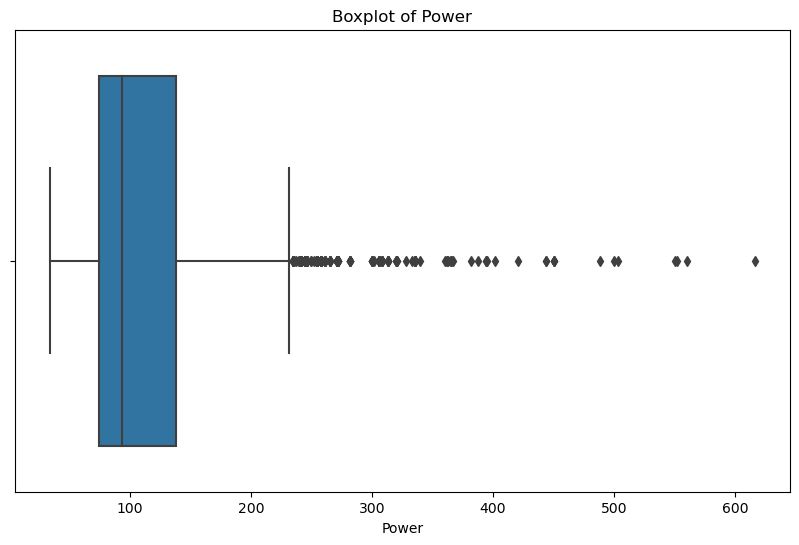

In [48]:
# Power 이상치
plt.figure(figsize=(10, 6))
sns.boxplot(x=Car_raw['Power'])
plt.title('Boxplot of Power')
plt.xlabel('Power')
plt.show()

In [49]:
new_titanic = Car_raw['Power'].value_counts()
new_titanic

74.00     292
98.60     166
73.90     152
140.00    142
78.90     134
         ... 
360.00      1
120.69      1
83.11       1
80.90       1
301.73      1
Name: Power, Length: 379, dtype: int64

Power의 이상치로 판단되는 값들을 출력하여 확인한 결과, 실제 모델들의 Power와 동일한 것을 확인할 수 있었다. 즉 Power는 이상치가 없다고 판단 된다.


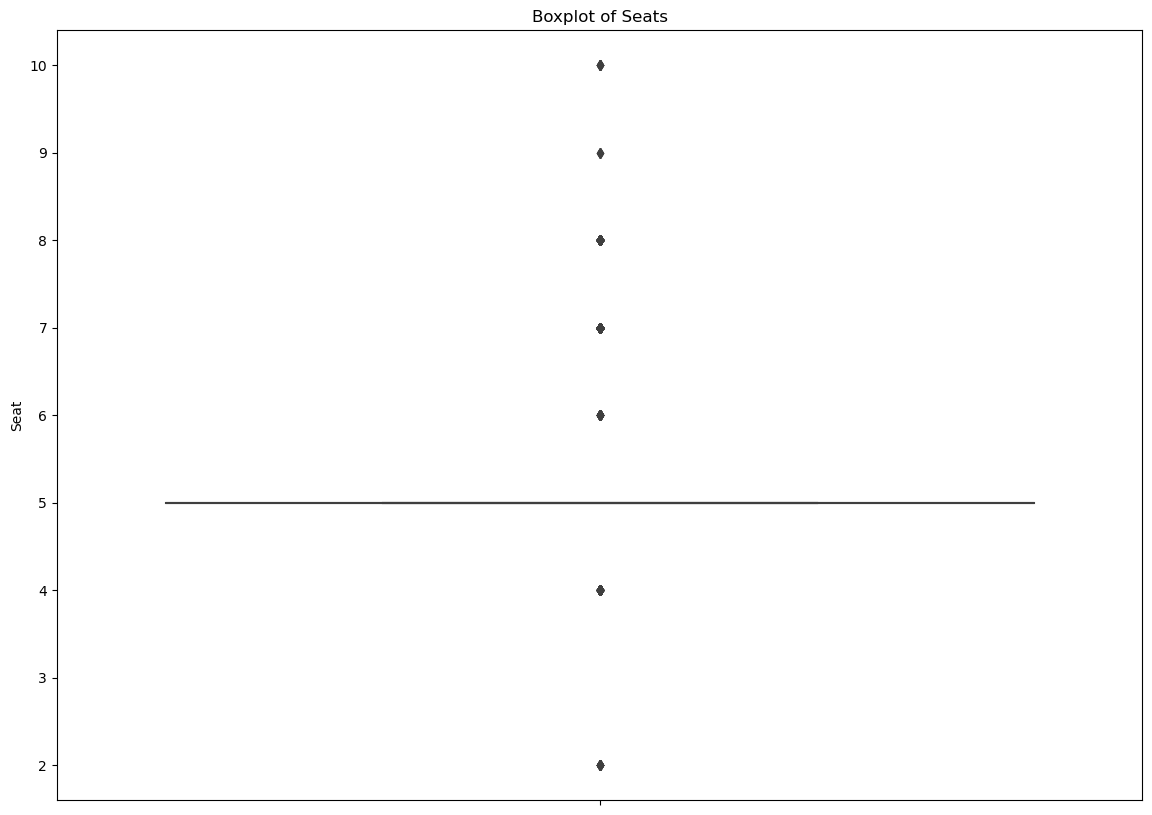

In [50]:
# Seats 이상치
plt.figure(figsize=(14, 10))
sns.boxplot(y=Car_raw['Seats'])
plt.title("Boxplot of Seats")
plt.ylabel("Seat")
plt.show()

seats도 이상치 없다고 판단

## Y축 정규화

Text(0.5, 1.0, 'Price Distribution')

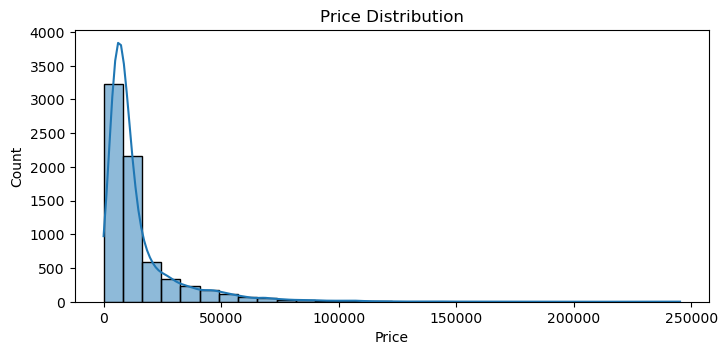

In [51]:
plt.figure(figsize=(18, 12))

# Price 히스토그램
plt.subplot(3, 2, 1)
sns.histplot(Car_raw['Price'].dropna(), bins=30, kde=True)
plt.title('Price Distribution')


In [52]:
y_log_transformed = np.log1p(Car_raw['Price'].to_numpy().reshape(-1, 1))

scaler = StandardScaler()
y_normalized = scaler.fit_transform(y_log_transformed)
y_normalized

array([[-1.81274634],
       [ 1.19115916],
       [ 1.11824661],
       ...,
       [ 0.64237231],
       [ 1.53982475],
       [ 1.34352153]])

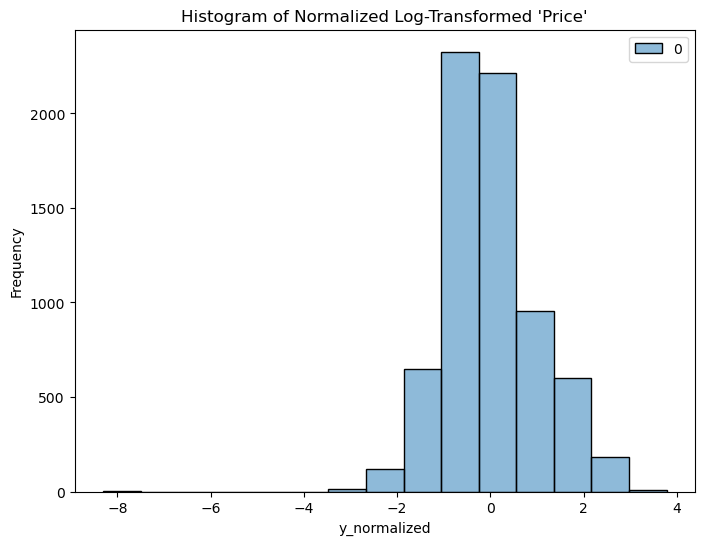

In [53]:
plt.figure(figsize=(8, 6))
sns.histplot(y_normalized, bins=15, color="skyblue")
plt.title("Histogram of Normalized Log-Transformed 'Price'")
plt.xlabel("y_normalized")
plt.ylabel("Frequency")
plt.show()


# 2. 가설세우기

1. Name은 가격에 영향을 주는 설명 변수일 것이다.
2. Location 가격에 영향을 주지 않는 설명 변수일 것이다.
3. Year는 가격에 영향을 주는  설명 변수일 것이다.
4. Kilometers_Driven은 가격에 영향을 주는 설명 변수일 것이다.
5. Fuel_Type는 가격에 영향을 주는 설명 변수일 것이다.
6. Transmission은 가격에 영향을 주는 설명 변수일 것이다.
7. Owner_Type는 가격에 영향을 주는 설명 변수일 것이다.
8. Mileage는 가격에 영향을 주는 설명 변수일 것이다. (근데, 이제… Name에 곁들어진.. 나야.. Mileage..)
9. Engine는 가격에 영향을 주는 설명 변수일 것이다. (근데, 이제… Name에 곁들어진.. 나야.. Engine..)
10. Power는 가격에 영향을 주는 설명 변수일 것이다. (근데, 이제… Name에 곁들어진.. 나야.. Power..)
11. Seats는 가격에 영향을 주는 설명 변수일 것이다. (근데, 이제… Name에 곁들어진.. 나야.. Seats..)
12. New_Price는 가격에 영향을 주지 않는 설명 변수일 것이다.

# 3. EDA

# 3-1 그래프

In [54]:
Car = Car_raw
brand = Car.groupby(by=['Brand'], as_index=True).count()

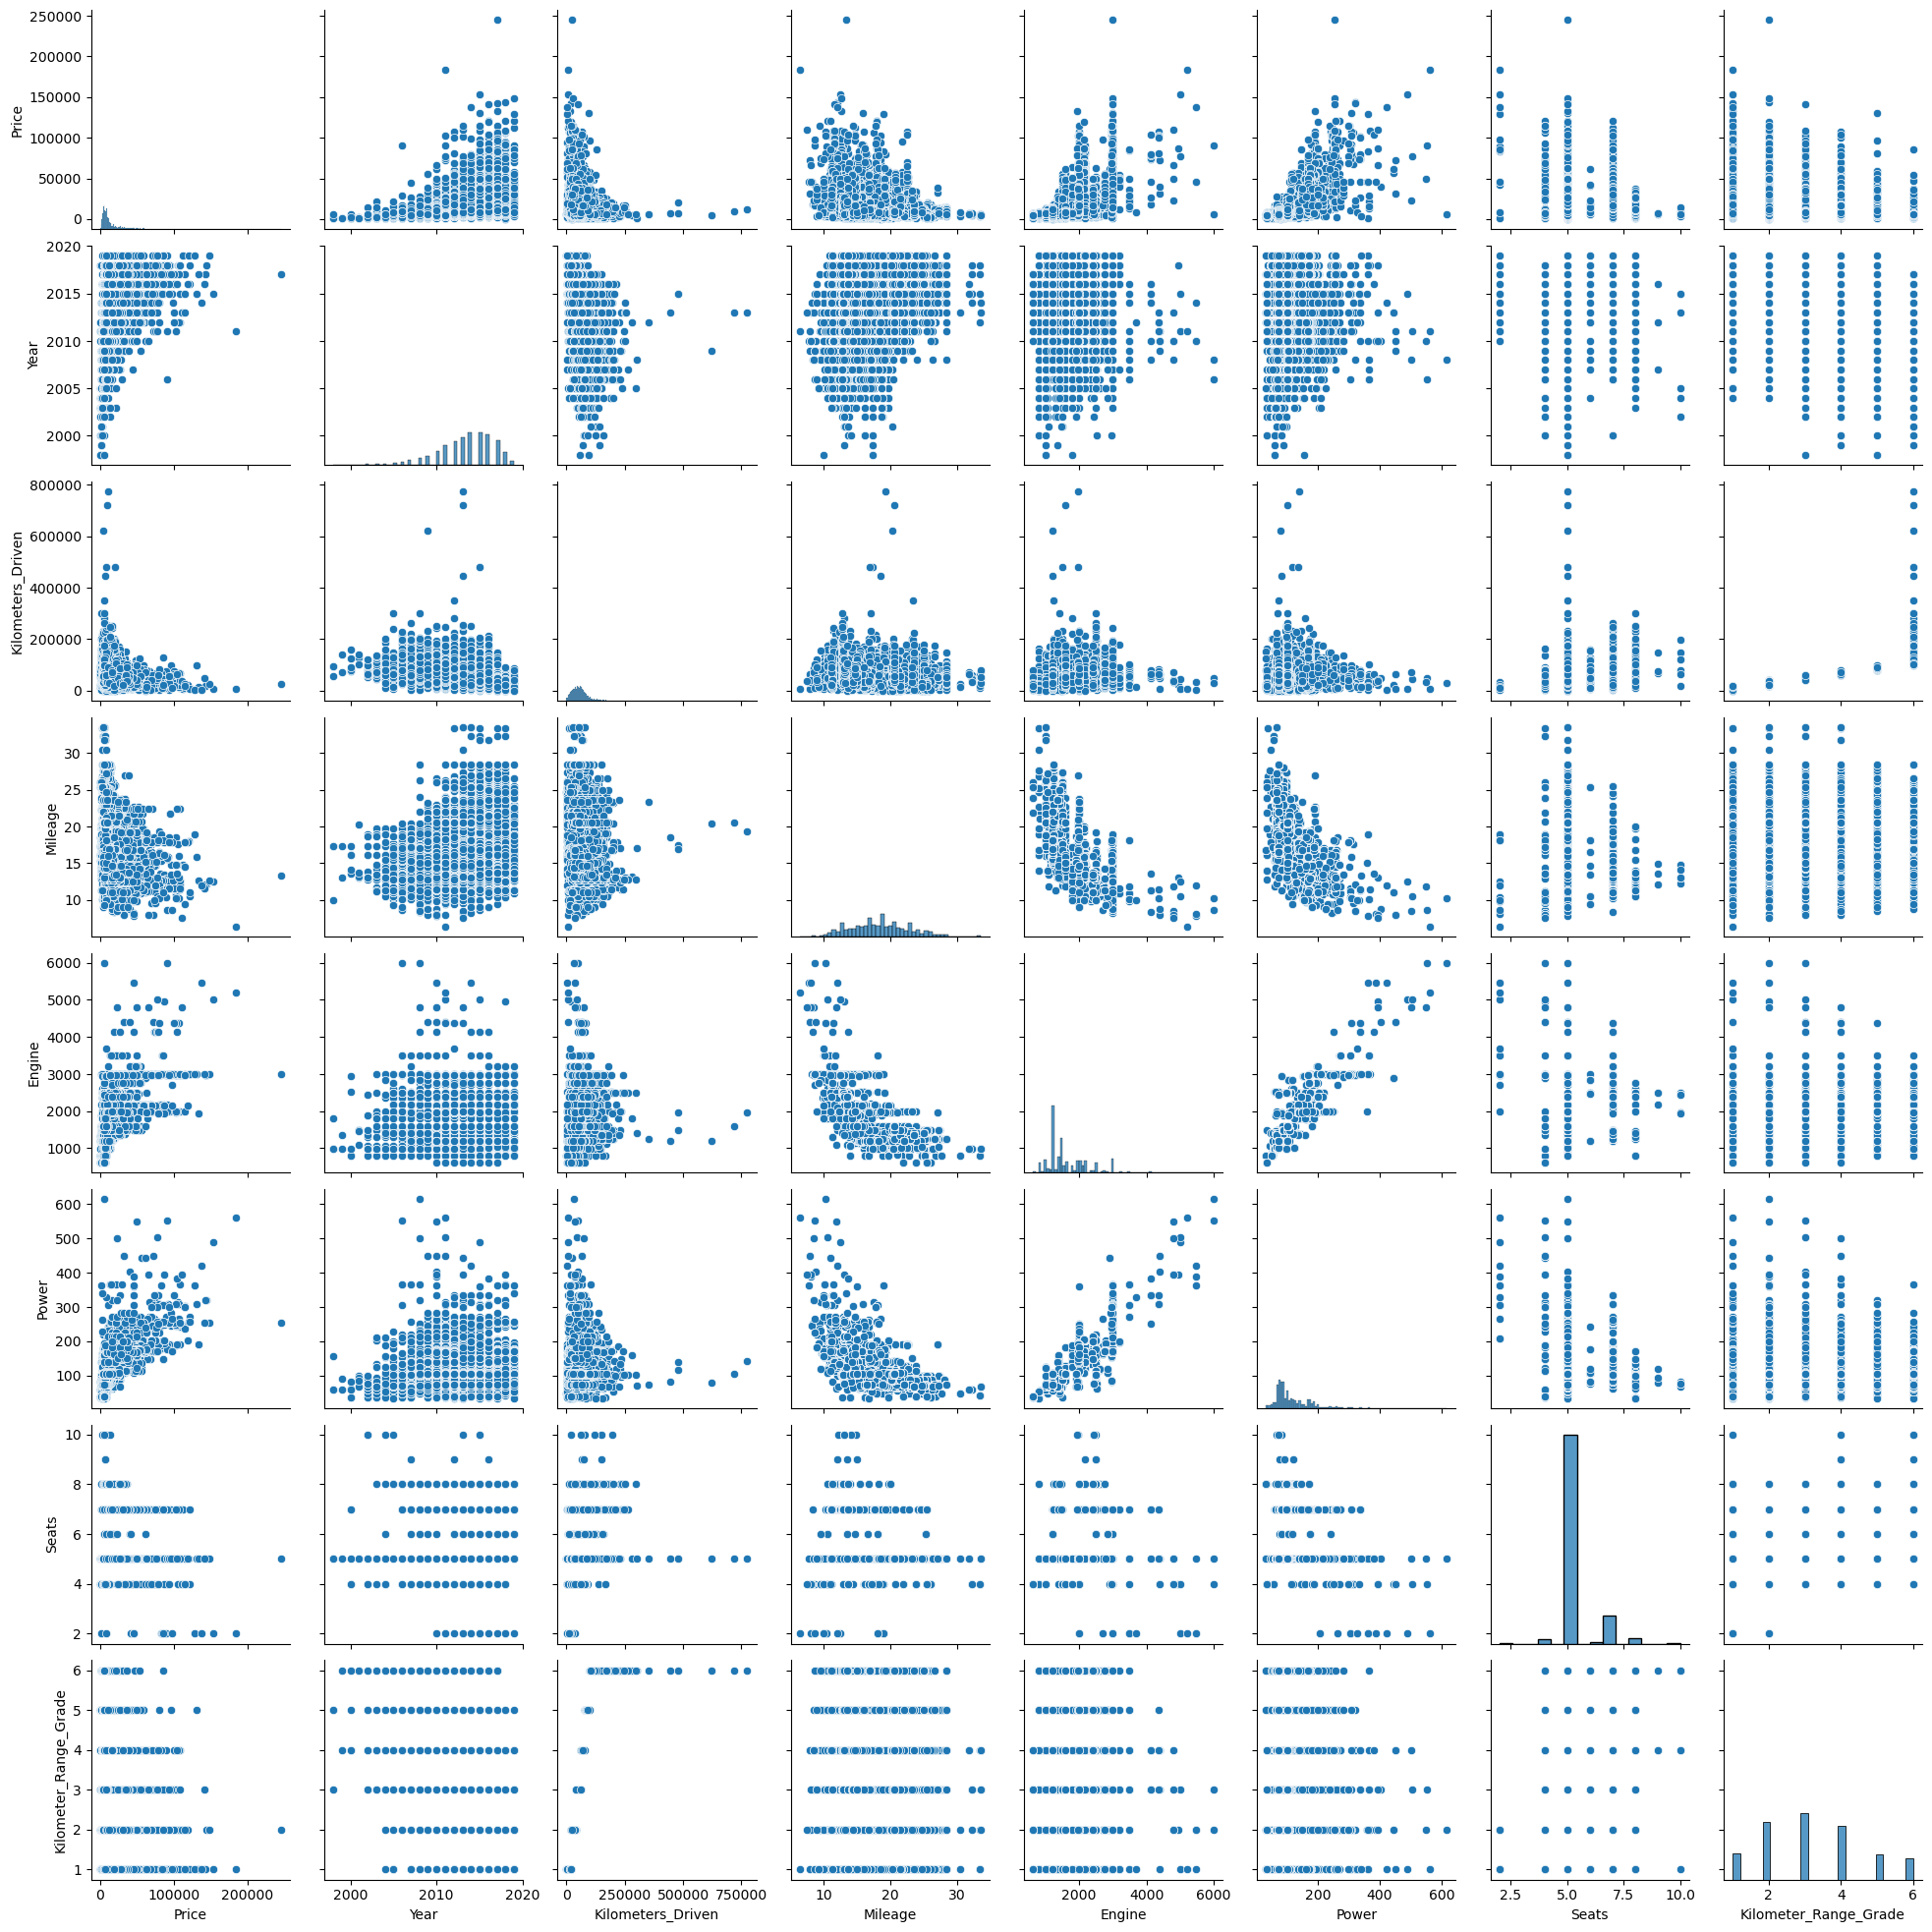

In [55]:
sns.pairplot(Car_raw)

'Power'와 'Engine'사이에 다중 공선성 확인

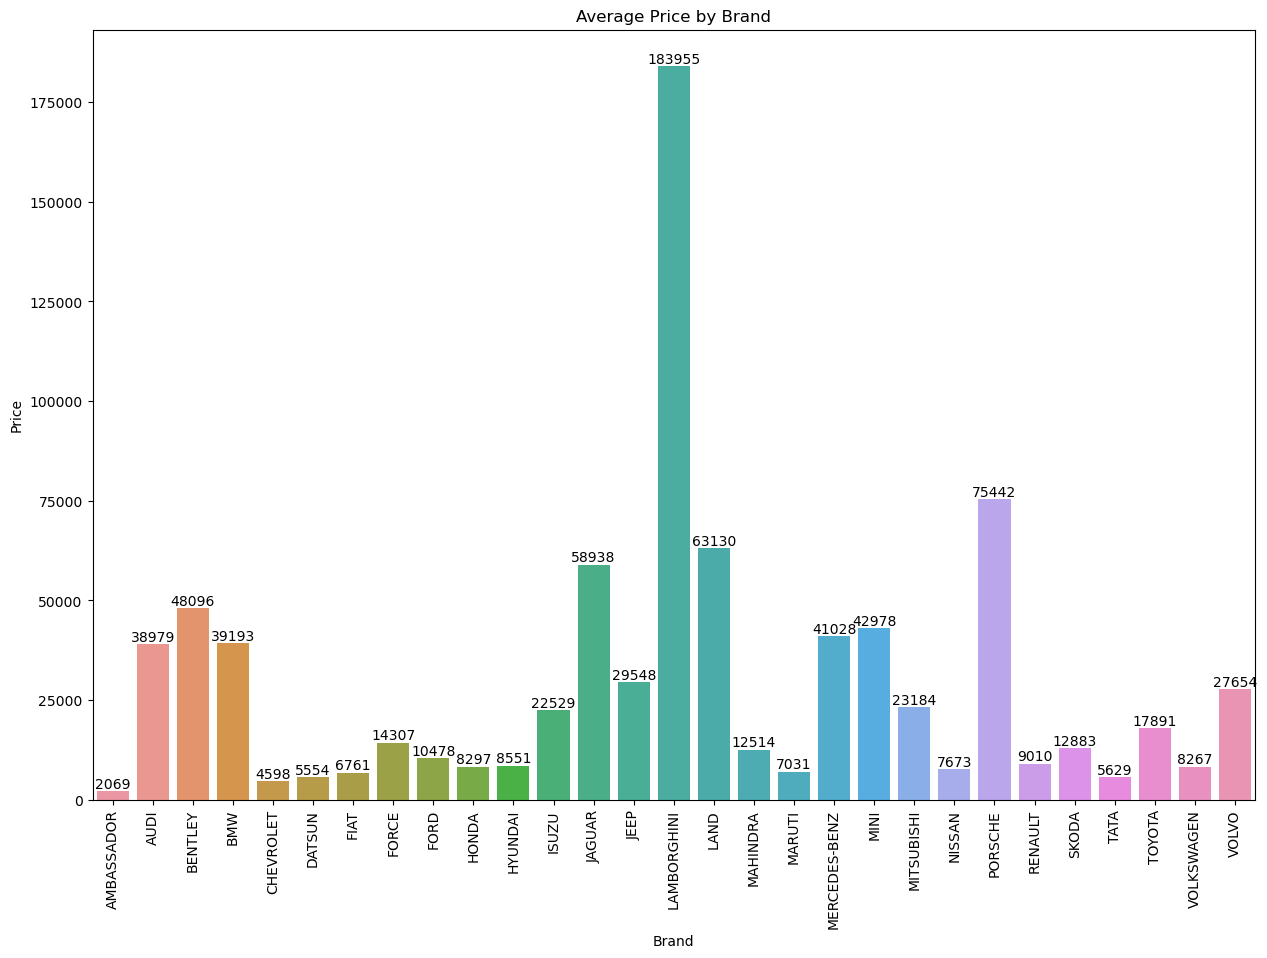

In [56]:
plt.figure(figsize=(15, 10)) 
p5=sns.barplot(x='Brand', y='Price', data=Car_raw, ci=None)

for container in p5.containers:
    p5.bar_label(container, fmt='%d')

plt.title('Average Price by Brand') 
# x축 레이블 90도 회전
plt.xticks(rotation=90)
plt.show()

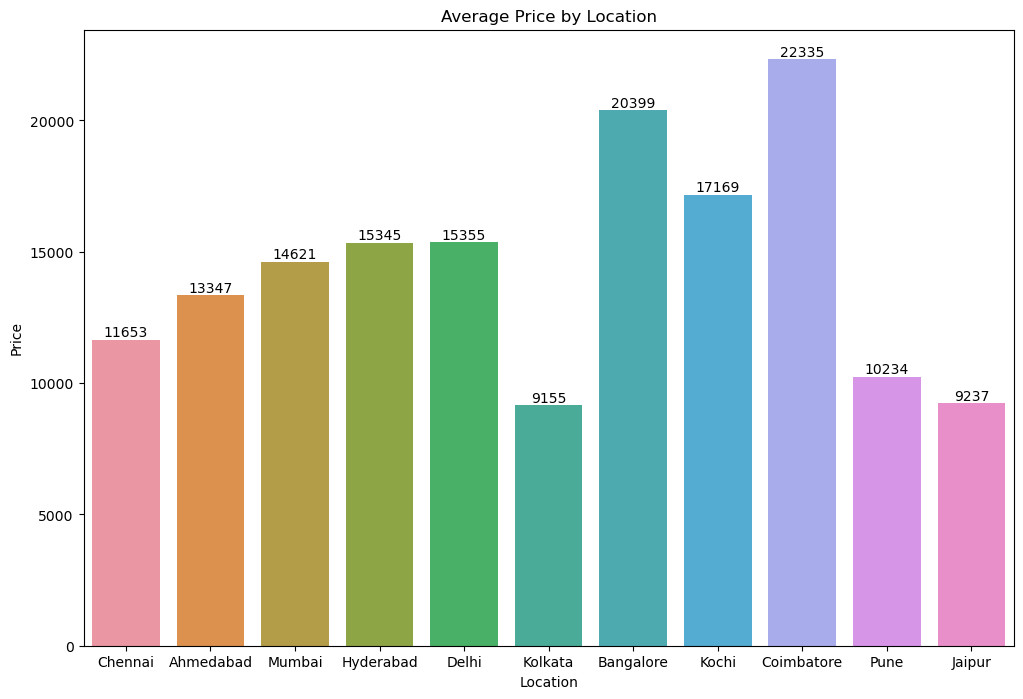

In [57]:
plt.figure(figsize=(12, 8)) 
p1=sns.barplot(x='Location', y='Price', data=Car_raw, ci=None)

for container in p1.containers:
    p1.bar_label(container, fmt='%d')

plt.title('Average Price by Location')
plt.show()

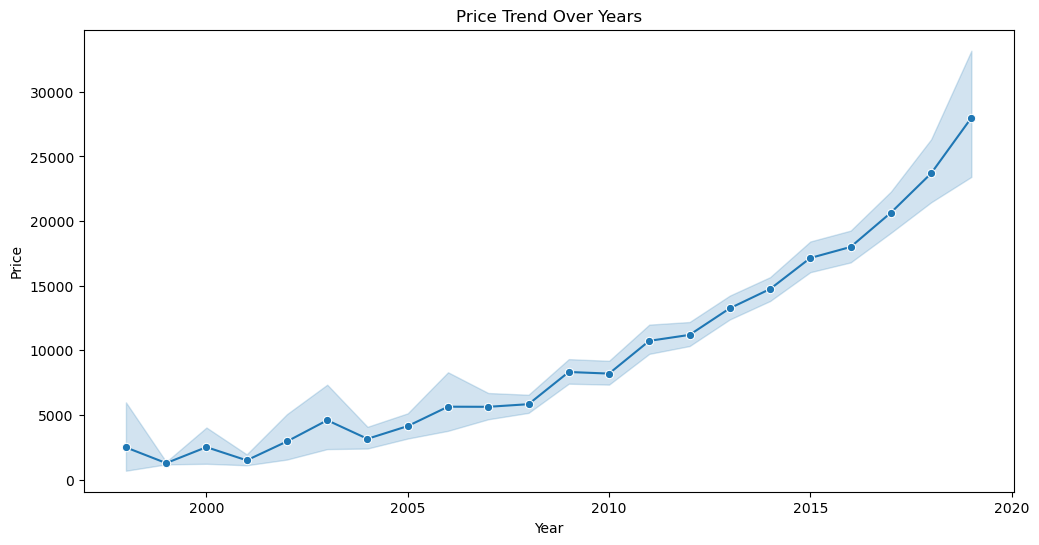

In [58]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Price', data=Car_raw, marker='o')

plt.title('Price Trend Over Years')
plt.show()

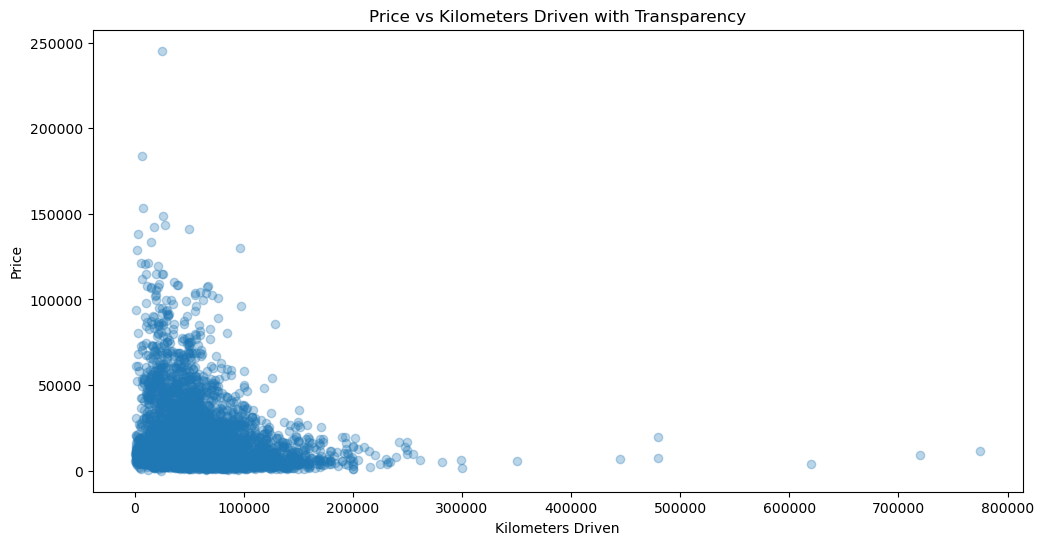

In [59]:
plt.figure(figsize=(12, 6))
plt.scatter(Car_raw['Kilometers_Driven'], Car_raw['Price'], alpha=0.3)  # alpha로 투명도 조절
plt.title('Price vs Kilometers Driven with Transparency')
plt.xlabel('Kilometers Driven')
plt.ylabel('Price')
plt.show()


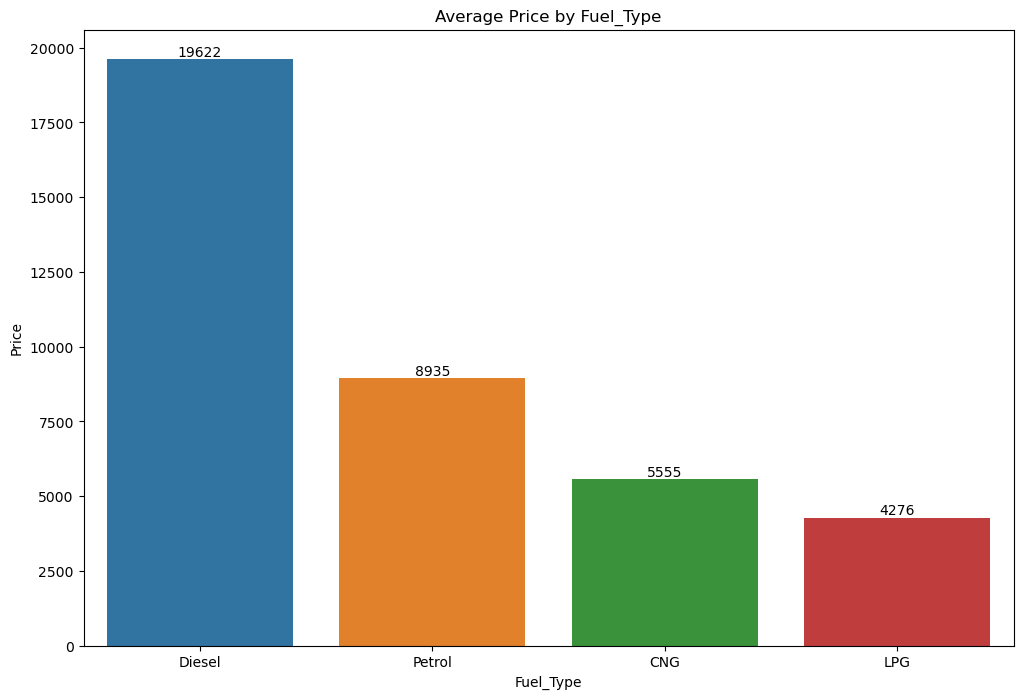

In [60]:
plt.figure(figsize=(12, 8)) 
p2=sns.barplot(x='Fuel_Type', y='Price', data=Car_raw, ci=None)

for container in p2.containers:
    p2.bar_label(container, fmt='%d')
    
plt.title('Average Price by Fuel_Type')    
plt.show()

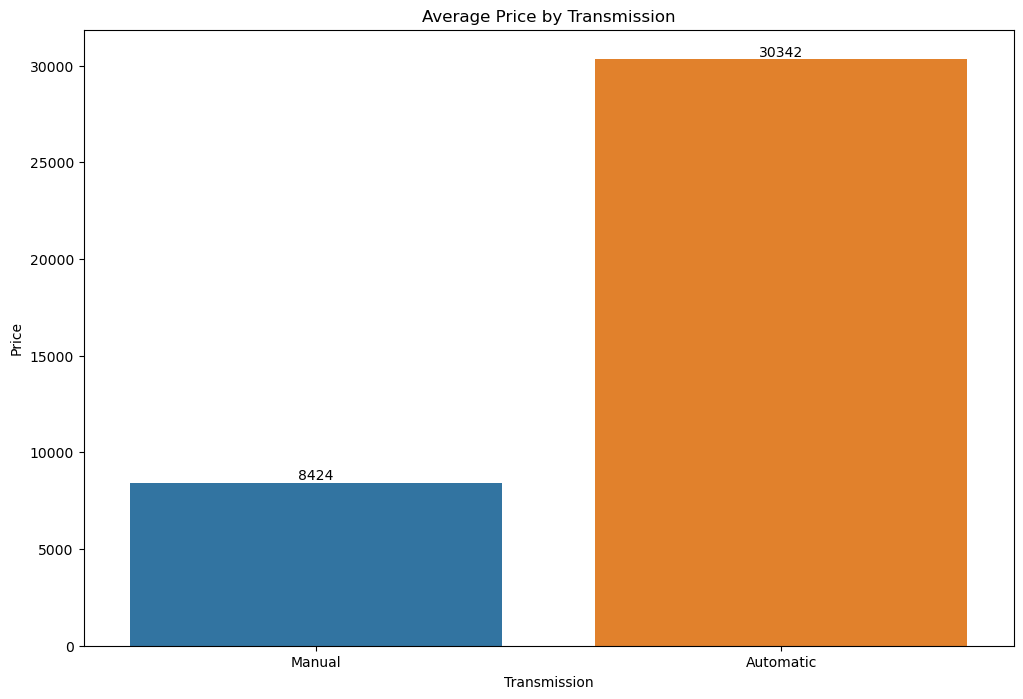

In [61]:
plt.figure(figsize=(12, 8)) 
p3=sns.barplot(x='Transmission', y='Price', data=Car_raw, ci=None)

for container in p3.containers:
    p3.bar_label(container, fmt='%d')

plt.title('Average Price by Transmission') 
plt.show()

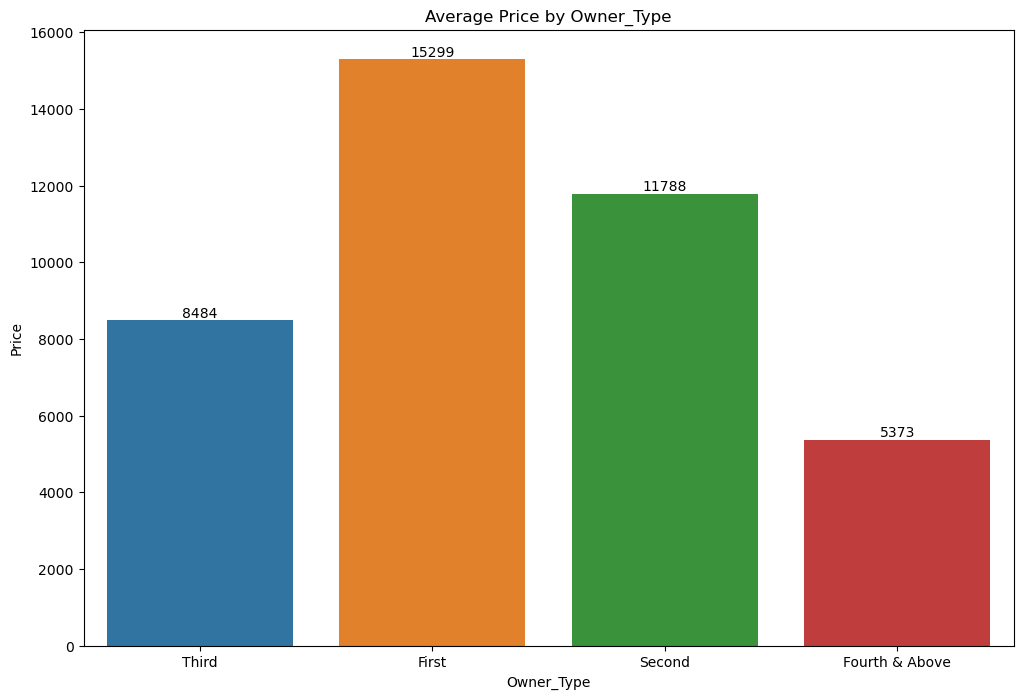

In [62]:
plt.figure(figsize=(12, 8)) 
p4=sns.barplot(x='Owner_Type', y='Price', data=Car_raw, ci=None)

for container in p4.containers:
    p4.bar_label(container, fmt='%d')

plt.title('Average Price by Owner_Type') 
plt.show()


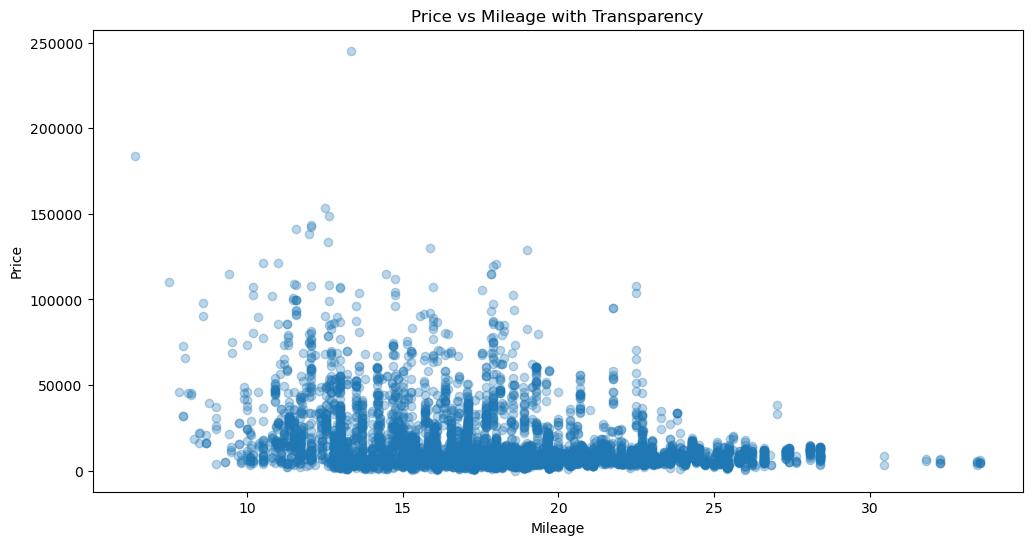

In [63]:
plt.figure(figsize=(12, 6))
plt.scatter(Car_raw['Mileage'], Car_raw['Price'], alpha=0.3) 
plt.title('Price vs Mileage with Transparency')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

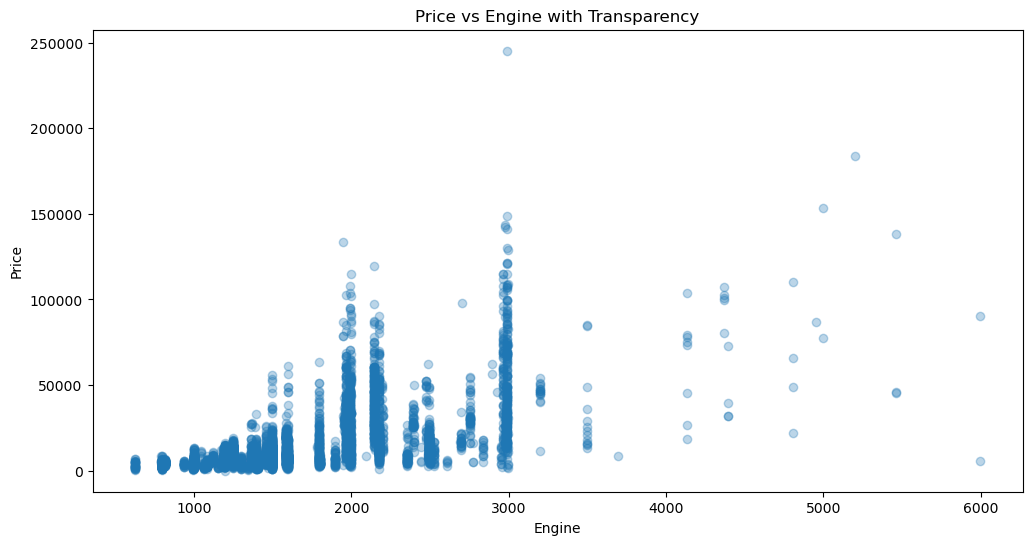

In [64]:
plt.figure(figsize=(12, 6))
plt.scatter(Car_raw['Engine'], Car_raw['Price'], alpha=0.3) 
plt.title('Price vs Engine with Transparency')
plt.xlabel('Engine')
plt.ylabel('Price')
plt.show()

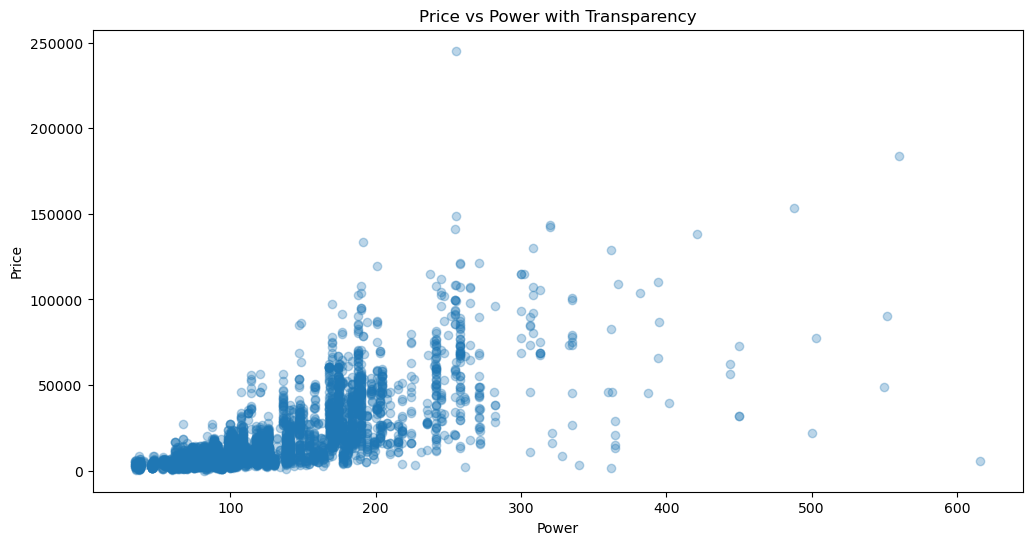

In [65]:
plt.figure(figsize=(12, 6))
plt.scatter(Car_raw['Power'], Car_raw['Price'], alpha=0.3) 
plt.title('Price vs Power with Transparency')
plt.xlabel('Power')
plt.ylabel('Price')
plt.show()

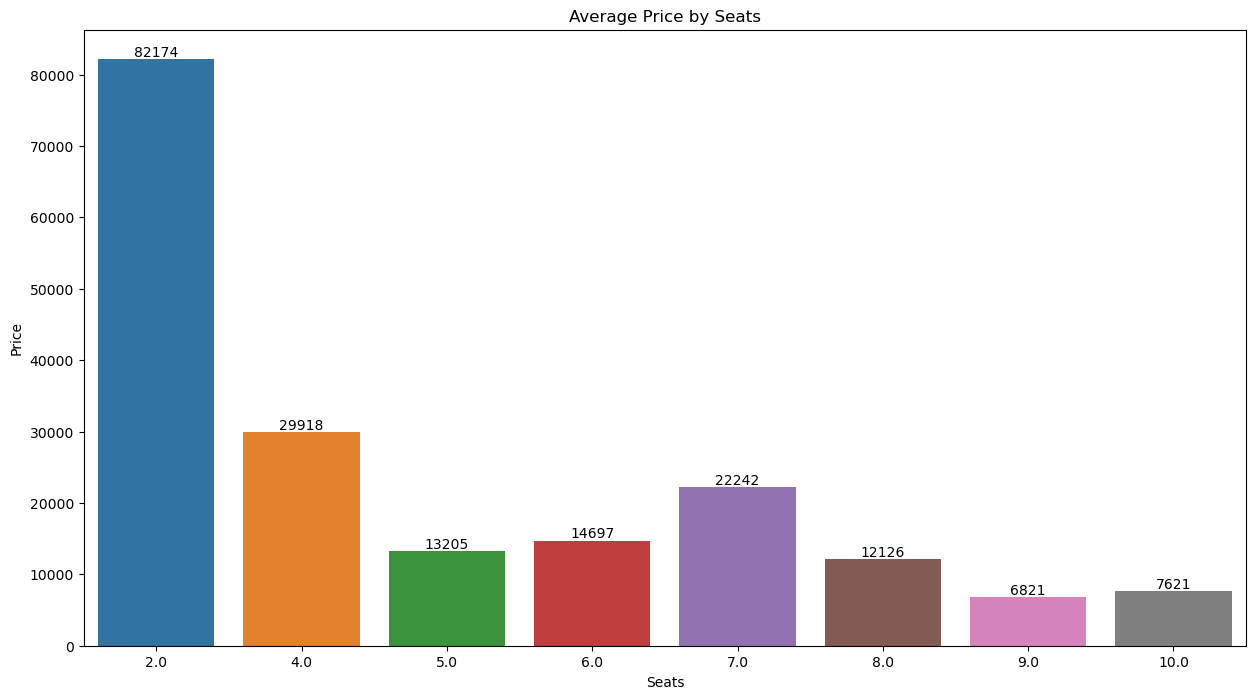

In [66]:
plt.figure(figsize=(15, 8)) 
p7=sns.barplot(x='Seats', y='Price', data=Car_raw, ci=None)

for container in p7.containers:
    p7.bar_label(container, fmt='%d')

plt.title('Average Price by Seats')
plt.show()


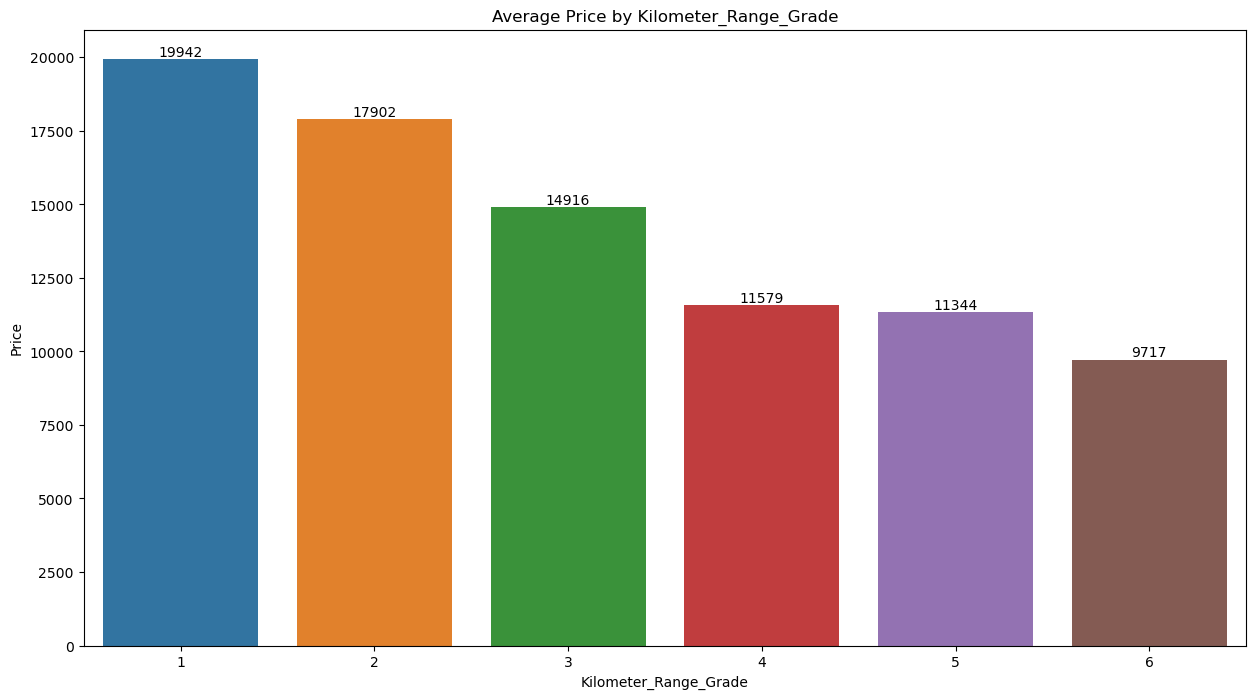

In [67]:
plt.figure(figsize=(15, 8)) 
p6=sns.barplot(x='Kilometer_Range_Grade', y='Price', data=Car_raw, ci=None)

for container in p6.containers:
    p6.bar_label(container, fmt='%d')

plt.title('Average Price by Kilometer_Range_Grade')
plt.show()

# 3-2 검정

# 범주형 데이터 
( Brand, Location, Fuel_type,  Transmission, Owner_type )

## T 검정 

In [83]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp

%matplotlib inline

plt.rc("font", family="NanumGothic Eco")
matplotlib.rc("axes", unicode_minus = False)

import warnings
warnings.filterwarnings('ignore')

### Brand

In [77]:
# 전체 가격의 평균 계산
overall_mean = Car_raw['Price'].mean()

# 브랜드 목록
brands = Car_raw['Brand'].unique()

# t-검정 결과 저장용 데이터프레임
t_test_results = pd.DataFrame(columns=['Brand', 't-statistic', 'p-value'])

# 각 브랜드에 대해 t-검정 수행
for brand in brands:
    # 해당 브랜드의 가격 데이터 추출
    price_brand = Car_raw[Car_raw['Brand'] == brand]['Price']
    
    # t-검정 수행: 브랜드의 가격 데이터와 전체 평균 비교
    t, p = ttest_1samp(price_brand, overall_mean)
    
    # 결과 저장
    t_test_results = t_test_results.append({
        'Brand': brand,
        't-statistic': t,
        'p-value': p
    }, ignore_index=True)

# 결과 출력
print(t_test_results)


            Brand  t-statistic        p-value
0      AMBASSADOR          NaN            NaN
1            AUDI    21.603549   9.655508e-62
2         BENTLEY     0.790505   5.741495e-01
3             BMW    18.217827   1.349716e-50
4       CHEVROLET   -45.397453   3.764993e-89
5          DATSUN   -19.616102   1.289909e-12
6            FIAT   -12.024526   3.300256e-13
7           FORCE    -0.152977   8.924564e-01
8            FORD    -6.920403   2.239835e-11
9           HONDA   -43.092542  1.092279e-203
10        HYUNDAI   -41.275174  4.643426e-237
11          ISUZU     1.460145   2.816856e-01
12         JAGUAR    11.377018   4.237922e-15
13           JEEP    15.191124   1.042729e-11
14    LAMBORGHINI          NaN            NaN
15           LAND    10.076989   3.460358e-14
16       MAHINDRA    -7.342680   1.686192e-12
17         MARUTI   -81.274227   0.000000e+00
18  MERCEDES-BENZ    20.325781   7.190615e-62
19           MINI    14.916687   2.032904e-15
20     MITSUBISHI     3.070196   4

In [82]:
Car_raw['Brand'].value_counts()

MARUTI           1416
HYUNDAI          1274
HONDA             739
TOYOTA            503
VOLKSWAGEN        373
MERCEDES-BENZ     364
FORD              342
MAHINDRA          327
BMW               304
AUDI              283
TATA              224
SKODA             198
RENAULT           170
CHEVROLET         150
NISSAN            113
LAND               57
JAGUAR             48
MITSUBISHI         36
FIAT               32
MINI               31
VOLVO              28
JEEP               19
PORSCHE            17
DATSUN             17
ISUZU               3
FORCE               3
BENTLEY             2
AMBASSADOR          1
LAMBORGHINI         1
Name: Brand, dtype: int64

유의미한 브랜드: AUDI와 BMW, MERCEDES-BENZ는 가격이 전체 평균보다 높으며, 가격에 유의미한 영향을 미친다. 반면 CHEVROLET와 HONDA는 가격이 전체 평균보다 낮고, 가격에 유의미한 영향을 미친다.
    
무의미한 브랜드: BENTLEY, ISUZU, FORCE는 P-value가 높아 가격이 전체 평균과 통계적으로 유의미한 차이를 보이지 않는다.
LAMBORGHINI, AMBASSADOR 는 value 가 1개만 존재해서 t 검정이 불가하다.

### Location

In [86]:
Car_raw['Location'].unique()

array(['Chennai', 'Ahmedabad', 'Mumbai', 'Hyderabad', 'Delhi', 'Kolkata',
       'Bangalore', 'Kochi', 'Coimbatore', 'Pune', 'Jaipur'], dtype=object)

In [87]:
locations = Car_raw['Location'].unique()

t_test_results = pd.DataFrame(columns=['Location', 't-statistic', 'p-value'])

for loc in locations:
    price_loc = Car_raw[Car_raw['Location'] == loc]['Price']
    t, p= ttest_1samp(price_loc, overall_mean)
    t_test_results = t_test_results.append({
        'Location': loc,
        't-statistic': t,
        'p-value': p
    }, ignore_index=True)

print(t_test_results)

      Location  t-statistic       p-value
0      Chennai    -5.179116  3.098599e-07
1    Ahmedabad    -1.558202  1.203743e-01
2       Mumbai     0.002207  9.982394e-01
3    Hyderabad     1.135346  2.565513e-01
4        Delhi     1.038354  2.994907e-01
5      Kolkata   -12.231934  4.775788e-31
6    Bangalore     5.618485  3.503303e-08
7        Kochi     3.877791  1.145069e-04
8   Coimbatore     9.516892  2.309692e-20
9         Pune   -10.544966  2.620544e-24
10      Jaipur   -12.701604  4.278017e-32


유의미한 위치: Chennai, Kolkata, Bangalore, Kochi, Coimbatore, Pune, Jaipur는 가격과 유의미한 관계가 있으며, 특히 Chennai와 Kolkata는 가격이 평균보다 낮고 Bangalore와 Coimbatore는 가격이 평균보다 높은 것으로 나타났다.

비유의미한 위치: Ahmedabad, Mumbai, Hyderabad, Delhi는 가격에 대한 유의미한 영향을 미치지 않으므로, 이들을 통해 가격 변화에 대한 인사이트를 얻기 어렵다.



### Fuel_Type

In [92]:
Car_raw['Fuel_Type'].unique()

array(['Diesel', 'Petrol', 'CNG', 'LPG'], dtype=object)

In [93]:
fuel_types = Car_raw['Fuel_Type'].unique()

t_test_results = pd.DataFrame(columns=['Fuel_Type', 't-statistic', 'p-value'])

for fuel in fuel_types:
    price_fuel = Car_raw[Car_raw['Fuel_Type'] == fuel]['Price']
    t, p = ttest_1samp(price_fuel, overall_mean)
    t_test_results = t_test_results.append({
        'Fuel_Type': fuel,
        't-statistic': t,
        'p-value': p
    }, ignore_index=True)

print(t_test_results)

  Fuel_Type  t-statistic        p-value
0    Diesel    15.855799   7.202116e-55
1    Petrol   -28.689828  2.324655e-161
2       CNG   -33.382969   1.870128e-40
3       LPG   -22.238960   1.707181e-10


Diesel: t-statistic이 높고 p-value가 매우 낮아, Diesel 차량의 가격이 전체 평균보다 유의미하게 높은 것으로 나타났다.

Petrol, CNG, LPG: 이 세 가지 연료 유형의 차량은 모두 t-statistic이 낮고 p-value가 매우 낮아, 가격이 전체 평균보다 유의미하게 낮은 것으로 해석된다.

### Transmission

In [94]:
Car_raw['Transmission'].unique()

array(['Manual', 'Automatic'], dtype=object)

In [100]:
Transmissions = Car_raw['Transmission'].unique()

t_test_results = pd.DataFrame(columns=['Transmission', 't-statistic', 'p-value'])

for transmission in Transmissions:
    Transmission = Car_raw[Car_raw['Transmission'] == transmission]['Price']
    t, p = ttest_1samp(Transmission, overall_mean)
    t_test_results = t_test_results.append({
        'Transmission': transmission,
        't-statistic': t,
        'p-value': p
    }, ignore_index=True)

print(t_test_results)


  Transmission  t-statistic        p-value
0       Manual   -78.971835   0.000000e+00
1    Automatic    28.811277  5.737449e-153


Manual: t-statistic이 매우 낮고 p-value가 0에 가까워, Manual 차량의 가격이 전체 평균보다 유의미하게 낮다는 것을 나타냅니다.

Automatic: t-statistic이 높고 p-value가 매우 낮아, Automatic 차량의 가격이 전체 평균보다 유의미하게 높다는 결과를 보여줍니다.

### Owner_Type

In [102]:
owner_types = Car_raw['Owner_Type'].unique()

t_test_results = pd.DataFrame(columns=['Owner_Type', 't-statistic', 'p-value'])

for owner in owner_types:
    price_owner = Car_raw[Car_raw['Owner_Type'] == owner]['Price']
    t, p = ttest_1samp(price_owner, overall_mean)
    t_test_results = t_test_results.append({
        'Owner_Type': owner,
        't-statistic': t,
        'p-value': p
    }, ignore_index=True)
    
print(t_test_results)

       Owner_Type  t-statistic       p-value
0           Third    -3.856156  1.840012e-04
1           First     2.990103  2.800464e-03
2          Second    -6.592245  6.712011e-11
3  Fourth & Above   -15.132901  3.598652e-07


Third, Second, Fourth & Above는 가격이 전체 평균보다 유의미하게 낮고, First는 가격이 전체 평균보다 유의미하게 높다.

## price - 범주형 변수 간의 관계

### 등분산성 검정

Levene's Test:

    각 집단의 데이터의 분산이 동일한지 검정하는 방법입니다. Levene's Test는 데이터의 분포가 정규 분포를 따르지 않아도 사용할 수 있습니다.

Bartlett's Test:

    이 검정은 여러 집단의 분산이 동일한지를 확인합니다. 하지만 데이터가 정규 분포를 따른다는 가정이 필요하므로, 정규성을 위반하는 경우에는 적합하지 않습니다.

Brown-Forsythe Test:

    Levene's Test와 유사하지만, 중앙값을 사용하는 변형입니다. 데이터의 분포가 정규성을 따르지 않는 경우에 더 강력하게 작용할 수 있습니다.

F-test:

    두 집단의 분산이 동일한지를 비교하는데 사용됩니다. 그러나 이 방법은 두 집단만 비교 가능하며, 데이터가 정규성을 가정해야 합니다.

Fligner-Killeen Test:

    비모수적 방법으로, 여러 집단의 분산이 같은지를 검정하는 방법입니다. 이 방법도 정규성 가정이 필요 없습니다.
    
우리는 **Levene's Test** 사용

In [107]:
import scipy.stats as stats

# 범주형 변수 목록
categorical_vars = ['Brand', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type']

# 등분산성 검정 결과 저장용 데이터프레임
homogeneity_results = pd.DataFrame(columns=['Category', 'Levene Stat', 'Levene p-value'])

# 등분산성 검정
for cat in categorical_vars:
    groups = [group['Price'].values for name, group in Car_raw.groupby(cat)]
    levene_stat, levene_p = stats.levene(*groups)
    homogeneity_results = homogeneity_results.append({
        'Category': cat,
        'Levene Stat': levene_stat,
        'Levene p-value': levene_p
    }, ignore_index=True)



print("\n등분산성 검정 결과:")
print(homogeneity_results)



등분산성 검정 결과:
       Category  Levene Stat  Levene p-value
0         Brand   109.148221    0.000000e+00
1      Location    25.722428    1.402785e-48
2     Fuel_Type   167.997150   3.334458e-105
3  Transmission  2686.504525    0.000000e+00
4    Owner_Type     6.640848    1.783833e-04


모든 범주형 변수(Brand, Location, Fuel_Type, Transmission, Owner_Type)에 대해 Levene의 p-값이 0.05보다 작으므로, 각 변수의 가격 분산은 동일하지 않으며, 등분산성 가정이 충족되지 않다. 

**ANOVA를 수행하기에 적합하지 않음.**
대신 비모수적 방법인 **Kruskal-Wallis H 검정을 사용.**

### Kruskal-Wallis H

In [110]:
from scipy.stats import kruskal 

# 각 범주형 변수에 대해 Kruskal-Wallis H 검정 수행
kruskal_results = pd.DataFrame(columns=['Category', 'H-statistic', 'p-value'])

for cat in categorical_vars:
    groups = [group['Price'].values for name, group in Car_raw.groupby(cat)]
    
    # Kruskal-Wallis H 검정 수행
    h_stat, p_val = kruskal(*groups)
    
    # 결과 저장
    kruskal_results = kruskal_results.append({
        'Category': cat,
        'H-statistic': h_stat,
        'p-value': p_val
    }, ignore_index=True)

# 결과 출력
print(kruskal_results)



       Category  H-statistic        p-value
0         Brand  3404.890806   0.000000e+00
1      Location   686.394696  5.227891e-141
2     Fuel_Type  1350.857584  1.356965e-292
3  Transmission  2246.870304   0.000000e+00
4    Owner_Type   214.923773   2.511798e-46


모든 범주형 변수(Brand, Location, Fuel_Type, Transmission, Owner_Type)가 가격에 유의미한 영향을 미친다는 결과를 보여준다. 특히 **Brand와 Transmission의 영향이 가장 크며,** Location과 Fuel_Type도 상당한 영향을 미친다

# 연속형 데이터
( Year, Kilometers_Driven, Kilometer_Range_Grade , Mileage, Engine, Power, Seats )

## 상관분석

In [117]:
# 상관 분석
correlation_matrix = Car_raw[['Year', 'Kilometers_Driven', 'Kilometer_Range_Grade', 'Mileage', 'Engine', 'Power', 'Seats', 'Price']].corr()

# 결과 출력
print(correlation_matrix['Price'])


Year                     0.289879
Kilometers_Driven       -0.163969
Kilometer_Range_Grade   -0.185566
Mileage                 -0.325087
Engine                   0.631356
Power                    0.750653
Seats                    0.058058
Price                    1.000000
Name: Price, dtype: float64


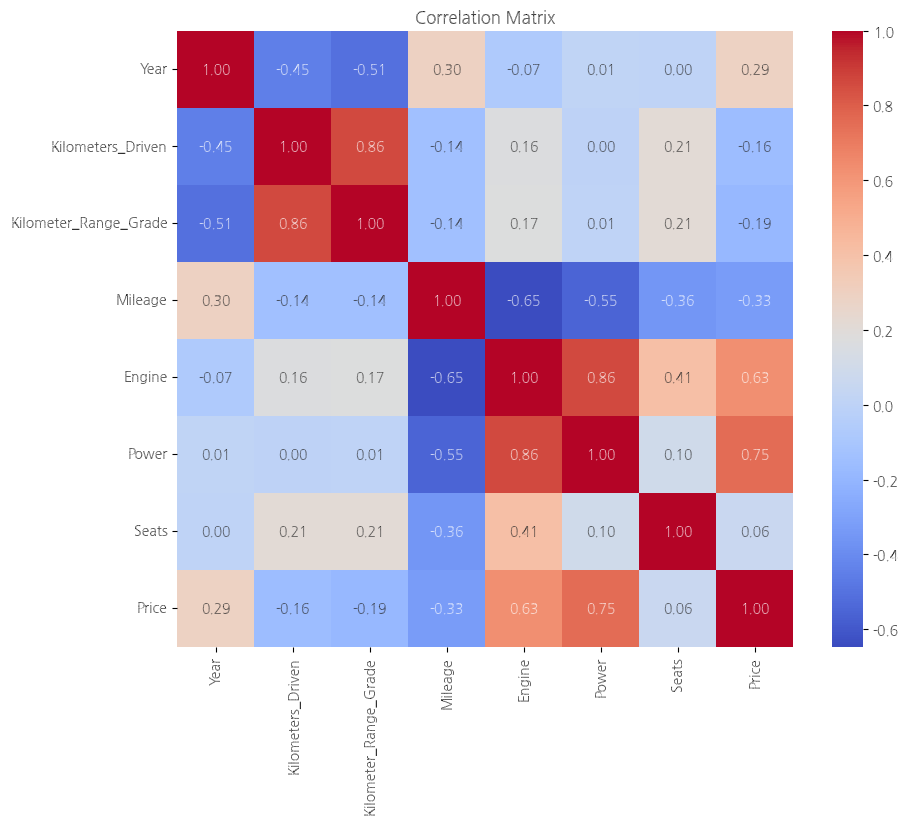

In [118]:
# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()

Power: Power와 Price 간의 상관계수는 0.751로 강한 양의 상관관계를 보입니다. 이는 차량의 출력이 증가함에 따라 가격도 상승하는 경향이 있음을 나타냅니다. 일반적으로 출력이 높은 차량은 더 높은 가치를 지니는 것으로 여겨집니다.

Engine: Engine과의 상관계수는 0.631으로 보통 강한 양의 상관관계를 나타내고 있습니다. 이는 엔진 크기가 큰 차량일수록 가격이 높아지는 경향이 있음을 시사합니다.

Mileage: Mileage와의 상관관계는 -0.325로 음의 상관관계를 보여줍니다. 이는 주행 거리가 증가할수록 가격이 감소하는 경향이 있음을 나타내며, 일반적으로 높은 주행 거리는 차량의 마모가 많음을 의미합니다.

Year: Year와의 상관계수는 0.290으로, 신차일수록 가격이 높아지는 경향이 있음을 시사합니다. 그러나 이 관계는 Power와 Engine보다는 약한 편입니다.

Kilometers Driven 및 Kilometer Range Grade는 모두 가격과 음의 상관관계를 보이며, 각각 -0.164와 -0.186의 상관계수를 가집니다. 이는 이러한 특성이 증가할수록 차량 가격이 낮아지는 경향이 있음을 나타냅니다.

Seats: Seats와의 상관관계는 매우 약한 0.058로, 차량의 좌석 수가 가격에 미치는 영향은 거의 없다고 볼 수 있습니다.